<a href="https://colab.research.google.com/github/Anacatlisboa23/Tese/blob/main/MIC_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIC Prediction

In [ ]:
# Importação das bibliotecas necessárias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import re
import csv

In [ ]:
data= pd.read_csv("/content/artigo_MICfeatures_mais_importantes_certo.csv")

In [ ]:
data

,Sequence,MIC,C,L,CV,KK,LK,PQ,PR,HP,...,R,Aromacity,length,PH,IsoelectricPoint,CR,QP,PP,WR,Y
0,AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS,2.099950,0.0,3.030,0.0,3.12,0.0,0.00,0.0,0.00,...,0.000,0.090909,33.0,0.00,10.001706,0.0,0.00,0.00,0.0,0.000
1,AAAAAAAIKMLMDLVNERIMALNKKAKK,1.000000,0.0,10.714,0.0,7.41,0.0,0.00,0.0,0.00,...,3.571,0.000000,28.0,0.00,10.171773,0.0,0.00,0.00,0.0,0.000
2,AAAKAALNAVLVGANA,1.903090,0.0,12.500,0.0,0.00,0.0,0.00,0.0,0.00,...,0.000,0.000000,16.0,0.00,8.795051,0.0,0.00,0.00,0.0,0.000
3,AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC,0.250463,15.0,5.000,0.0,2.56,0.0,0.00,0.0,0.00,...,7.500,0.050000,40.0,0.00,9.126870,0.0,0.00,0.00,0.0,0.000
4,AAGMGFFGAR,1.108874,0.0,0.000,0.0,0.00,0.0,0.00,0.0,0.00,...,10.000,0.200000,10.0,0.00,9.795020,0.0,0.00,0.00,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4541,YVLWKRKRWIFI,1.778151,0.0,8.333,0.0,0.00,0.0,0.00,0.0,0.00,...,16.667,0.333333,12.0,0.00,11.097153,0.0,0.00,0.00,0.0,8.333
4542,YVPLPNVPQPGRRPFPTFPGQGPFNPKIKWPQGY,0.548456,0.0,2.941,0.0,0.00,0.0,6.06,0.0,0.00,...,5.882,0.176471,34.0,0.00,10.446795,0.0,3.03,0.00,0.0,5.882
4543,YVPPVQKPHPNGPKFPTFP,1.364542,0.0,0.000,0.0,0.00,0.0,0.00,0.0,5.56,...,0.000,0.157895,19.0,5.56,9.703153,0.0,0.00,5.56,0.0,5.263
4544,YWKKWKKLRRIFMLV,-0.020287,0.0,13.333,0.0,14.29,0.0,0.00,0.0,0.00,...,13.333,0.266667,15.0,0.00,11.219707,0.0,0.00,0.00,0.0,6.667


In [ ]:
data.dropna(subset="MIC", inplace=True)

2002 dados de MICs

# Tratar o dataset:

In [ ]:
import pandas as pd
import re

def converter_valor(valor, unidade):
    conversoes = {
        'μg/ml': 1,
        'ng/ml': 1e-3,
        'nm': 1e-6,
        'μm': 1e-6,
        'mm': 1e-3,
        'g/l': 1e3,
        'mg/ml': 1e3,
    }
    fator_conversao = conversoes.get(unidade.lower(), None)
    if fator_conversao is None:
        raise ValueError(f"Unidade desconhecida: {unidade}")
    return valor * fator_conversao




In [ ]:
def converter_para_ug_ml(valor_str):
    try:
        if '-' in valor_str:
            partes = valor_str.split('-')
            valor_min = converter_para_ug_ml(partes[0].strip())
            valor_max = converter_para_ug_ml(partes[1].strip())
            if valor_min is not None and valor_max is not None:
                return (valor_min + valor_max) / 2  # Retornar a média dos valores
            return None

        operador = re.findall(r'[<>]=?|=', valor_str)
        operador = operador[0] if operador else ""
        valor_str = valor_str.replace(operador, '').strip()

        match = re.match(r'([0-9.]+)\s*([a-zA-Z/μµ]+)', valor_str)
        if not match:
            raise ValueError(f"Formato inválido: {valor_str}")

        valor = float(match.group(1))
        unidade = match.group(2)

        valor_convertido = converter_valor(valor, unidade)
        return valor_convertido

    except ValueError as e:
        print(f"Ignorando valor com erro: {e}")
        return None


In [ ]:

def converter_row(row):
    if isinstance(row, str):
        return converter_para_ug_ml(row.replace('MIC', '').strip())
    return None

In [ ]:

def processar_dataset(df):
    # Aplicar conversão para a coluna MIC
    df['MIC_padronizado'] = df['MIC'].apply(converter_row)

In [ ]:
# Comparar valores numéricos e padronizados
def verificar(row):
    mic_numerico = row.get('MIC_numerico', None)
    mic_padronizado = row.get('MIC_padronizado', None)

    if mic_numerico is not None and mic_padronizado is not None:
        return abs(mic_numerico - mic_padronizado) < 1e-6
    return None

In [ ]:
def processar_dataset(df):
    # Verificar a existência da coluna 'MIC'
    if 'MIC' not in df.columns:
        raise ValueError("Coluna 'MIC' não encontrada no DataFrame")

    # Aplicar conversão para a coluna MIC
    df['MIC_padronizado'] = df['MIC'].apply(converter_row)

    # Garantir que a coluna 'MIC_numerico' exista e não tenha valores nulos
    if 'MIC_numerico' not in df.columns:
        df['MIC_numerico'] = None

    # Comparar valores numéricos e padronizados
    df['Verificacao'] = df.apply(verificar, axis=1)

    return df



In [ ]:
df = pd.DataFrame(data)
df = processar_dataset(df)

Ignorando valor com erro: Formato inválido: ≤0.13 μg/ml
Ignorando valor com erro: Formato inválido: 0.2
Ignorando valor com erro: Formato inválido: 6.1
Ignorando valor com erro: Formato inválido: 48.8
Ignorando valor com erro: Formato inválido: 3
Ignorando valor com erro: Formato inválido: 6
Ignorando valor com erro: Formato inválido: 125
Ignorando valor com erro: Formato inválido: 250
Ignorando valor com erro: Formato inválido: 250
Ignorando valor com erro: Formato inválido: 250
Ignorando valor com erro: Formato inválido: 250
Ignorando valor com erro: Formato inválido: 250
Ignorando valor com erro: Formato inválido: 125
Ignorando valor com erro: Formato inválido: 1.25
Ignorando valor com erro: Formato inválido: 2.5
Ignorando valor com erro: Formato inválido: 1.25
Ignorando valor com erro: Formato inválido: 5
Ignorando valor com erro: Formato inválido: 2.5
Ignorando valor com erro: Formato inválido: 17.7
Ignorando valor com erro: Formato inválido: 4
Ignorando valor com erro: Formato in

In [ ]:
df.dropna(subset="MIC_padronizado", inplace= True)

In [ ]:
df

,Sequence,Name,Target_Organism,MIC,Function,MIC_padronizado,MIC_numerico,Verificacao
1,VTSWSLCTPGCTSPGGGSNCSFCC,Microbisporicin A1 (Bacteriocin),L Enterococcus faecium,MIC=2 μg/ml,antibacterian group ESKAPE,2.000000e+00,None,None
3,ATRSYGNGVYCNNSKCWVNWGEAKENIAGIVISGWASGLAGMGH,Enterocin P (Pediocin-like peptide; Bacteriocin),Enterococcus faecium,MIC=2 ng/ml,antibacterian group ESKAPE,2.000000e-03,None,None
6,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,Enterocin X alpha (Two-peptide bacteriocin),Enterococcus faecium 1344L,MIC=50.8 nM,antibacterian group ESKAPE,5.080000e-05,None,None
10,NRWYCNSAAGGVGGAAVCGLAGYVGEAKENIAGEVRKGWGMAGGFT...,Enterocin E-760 (Bacteriocin),Klebsiella pneumoniae,MIC=3.2 μg/ml,antibacterian group ESKAPE,3.200000e+00,None,None
11,LIDHLGAPRWAVDTILGAIAVGNLASWVLALVPGPGWAVKAGLATA...,Lactocyclicin Q (Bacteriocin),Enterococcus faecium,MIC=0.71 µM,antibacterian group ESKAPE,7.100000e-07,None,None
...,...,...,...,...,...,...,...,...
3603,GLLKKLLKIAAKVGKKLL,"XT-7 [G4K,P5K,S15K,N16K]",Staphylococcus aureus,MIC=6 µM,antibacterian group ESKAPE,6.000000e-06,None,None
3607,GLKEVAHSAKKFAKGFISGLTGS,Pxt‐3,Pseudomonas aeruginosa,MIC >256 µM,antibacterian group ESKAPE,2.560000e-04,None,None
3608,GLKEVAHSAKKFAKGFISGLTGS,Pxt‐3,Staphylococcus aureus,MIC >256 µM,antibacterian group ESKAPE,2.560000e-04,None,None
3616,NLLGSLLKTGLKVGSNLL,Pxt‐12(CPF-St7),Pseudomonas aeruginosa,MIC >256 µM,antibacterian group ESKAPE,2.560000e-04,None,None


1905 dados

In [ ]:
df.drop(columns=["MIC_numerico","Verificacao"])

,Sequence,Name,Target_Organism,MIC,Function,MIC_padronizado
1,VTSWSLCTPGCTSPGGGSNCSFCC,Microbisporicin A1 (Bacteriocin),L Enterococcus faecium,MIC=2 μg/ml,antibacterian group ESKAPE,2.000000e+00
3,ATRSYGNGVYCNNSKCWVNWGEAKENIAGIVISGWASGLAGMGH,Enterocin P (Pediocin-like peptide; Bacteriocin),Enterococcus faecium,MIC=2 ng/ml,antibacterian group ESKAPE,2.000000e-03
6,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,Enterocin X alpha (Two-peptide bacteriocin),Enterococcus faecium 1344L,MIC=50.8 nM,antibacterian group ESKAPE,5.080000e-05
10,NRWYCNSAAGGVGGAAVCGLAGYVGEAKENIAGEVRKGWGMAGGFT...,Enterocin E-760 (Bacteriocin),Klebsiella pneumoniae,MIC=3.2 μg/ml,antibacterian group ESKAPE,3.200000e+00
11,LIDHLGAPRWAVDTILGAIAVGNLASWVLALVPGPGWAVKAGLATA...,Lactocyclicin Q (Bacteriocin),Enterococcus faecium,MIC=0.71 µM,antibacterian group ESKAPE,7.100000e-07
...,...,...,...,...,...,...
3603,GLLKKLLKIAAKVGKKLL,"XT-7 [G4K,P5K,S15K,N16K]",Staphylococcus aureus,MIC=6 µM,antibacterian group ESKAPE,6.000000e-06
3607,GLKEVAHSAKKFAKGFISGLTGS,Pxt‐3,Pseudomonas aeruginosa,MIC >256 µM,antibacterian group ESKAPE,2.560000e-04
3608,GLKEVAHSAKKFAKGFISGLTGS,Pxt‐3,Staphylococcus aureus,MIC >256 µM,antibacterian group ESKAPE,2.560000e-04
3616,NLLGSLLKTGLKVGSNLL,Pxt‐12(CPF-St7),Pseudomonas aeruginosa,MIC >256 µM,antibacterian group ESKAPE,2.560000e-04


Guardar dataset:

In [ ]:
df.to_csv("/content/MIC_ESKAPE.csv", index=False)

# Com features:

In [ ]:
data=pd.read_csv("/content/meu_artigo_MICfeatures_mais_importantes_certo.csv")

In [ ]:
data

,Sequence,MIC,C,GL,L,KK,W,RR,YR,RV,...,Aromacity,WC,WQ,length,IsoelectricPoint,QW,V,VC,WR,Y
0,VTSWSLCTPGCTSPGGGSNCSFCC,2.000000e+00,20.833,0.00,4.167,0.00,4.167,0.0,0.0,0.0,...,0.083333,0.0,0.0,24.0,5.466399,0.0,4.167,0.00,0.0,0.000
1,ATRSYGNGVYCNNSKCWVNWGEAKENIAGIVISGWASGLAGMGH,2.000000e-03,4.545,2.33,2.273,0.00,6.818,0.0,0.0,0.0,...,0.113636,0.0,0.0,44.0,8.070491,0.0,6.818,0.00,0.0,4.545
2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,5.080000e-05,5.000,0.00,7.500,0.00,2.500,0.0,0.0,0.0,...,0.100000,0.0,0.0,40.0,8.769006,0.0,5.000,0.00,0.0,5.000
3,NRWYCNSAAGGVGGAAVCGLAGYVGEAKENIAGEVRKGWGMAGGFT...,3.200000e+00,4.839,1.64,1.613,0.00,4.839,0.0,0.0,0.0,...,0.112903,0.0,0.0,62.0,8.994645,0.0,6.452,1.64,0.0,3.226
4,LIDHLGAPRWAVDTILGAIAVGNLASWVLALVPGPGWAVKAGLATA...,7.100000e-07,0.000,1.67,11.475,0.00,6.557,0.0,0.0,0.0,...,0.065574,0.0,0.0,61.0,9.700058,0.0,9.836,0.00,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,GLLGPLLKIAAKVGSKLL,3.000000e-06,0.000,5.88,33.333,0.00,0.000,0.0,0.0,0.0,...,0.000000,0.0,0.0,18.0,10.302064,0.0,5.556,0.00,0.0,0.000
1008,GLLGKLLKIAAKVGKKLL,3.000000e-06,0.000,5.88,33.333,5.88,0.000,0.0,0.0,0.0,...,0.000000,0.0,0.0,18.0,10.602487,0.0,5.556,0.00,0.0,0.000
1009,GLLKKLLKIAAKVGKKLL,6.000000e-06,0.000,5.88,33.333,11.76,0.000,0.0,0.0,0.0,...,0.000000,0.0,0.0,18.0,10.699318,0.0,5.556,0.00,0.0,0.000
1010,GLKEVAHSAKKFAKGFISGLTGS,2.560000e-04,0.000,9.09,8.696,4.55,0.000,0.0,0.0,0.0,...,0.086957,0.0,0.0,23.0,10.001383,0.0,4.348,0.00,0.0,0.000


In [ ]:
data.drop(columns="Unnamed: 0", inplace=True)

# Com Protbert

In [ ]:
mic=pd.read_csv("/content/mic_data.csv")

In [ ]:
mic

,Sequence,Name,Target_Organism,MIC,Function,MIC_padronizado,MIC_numerico,Verificacao
0,VTSWSLCTPGCTSPGGGSNCSFCC,Microbisporicin A1 (Bacteriocin),L Enterococcus faecium,MIC=2 μg/ml,antibacterian group ESKAPE,2.000000e+00,NaN,NaN
1,ATRSYGNGVYCNNSKCWVNWGEAKENIAGIVISGWASGLAGMGH,Enterocin P (Pediocin-like peptide; Bacteriocin),Enterococcus faecium,MIC=2 ng/ml,antibacterian group ESKAPE,2.000000e-03,NaN,NaN
2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,Enterocin X alpha (Two-peptide bacteriocin),Enterococcus faecium 1344L,MIC=50.8 nM,antibacterian group ESKAPE,5.080000e-05,NaN,NaN
3,NRWYCNSAAGGVGGAAVCGLAGYVGEAKENIAGEVRKGWGMAGGFT...,Enterocin E-760 (Bacteriocin),Klebsiella pneumoniae,MIC=3.2 μg/ml,antibacterian group ESKAPE,3.200000e+00,NaN,NaN
4,LIDHLGAPRWAVDTILGAIAVGNLASWVLALVPGPGWAVKAGLATA...,Lactocyclicin Q (Bacteriocin),Enterococcus faecium,MIC=0.71 µM,antibacterian group ESKAPE,7.100000e-07,NaN,NaN
...,...,...,...,...,...,...,...,...
1900,GLLKKLLKIAAKVGKKLL,"XT-7 [G4K,P5K,S15K,N16K]",Staphylococcus aureus,MIC=6 µM,antibacterian group ESKAPE,6.000000e-06,NaN,NaN
1901,GLKEVAHSAKKFAKGFISGLTGS,Pxt‐3,Pseudomonas aeruginosa,MIC >256 µM,antibacterian group ESKAPE,2.560000e-04,NaN,NaN
1902,GLKEVAHSAKKFAKGFISGLTGS,Pxt‐3,Staphylococcus aureus,MIC >256 µM,antibacterian group ESKAPE,2.560000e-04,NaN,NaN
1903,NLLGSLLKTGLKVGSNLL,Pxt‐12(CPF-St7),Pseudomonas aeruginosa,MIC >256 µM,antibacterian group ESKAPE,2.560000e-04,NaN,NaN


In [ ]:
df_subset=mic[["Sequence","MIC_padronizado"]]

In [ ]:
df_subset

,Sequence,MIC_padronizado
0,VTSWSLCTPGCTSPGGGSNCSFCC,2.000000e+00
1,ATRSYGNGVYCNNSKCWVNWGEAKENIAGIVISGWASGLAGMGH,2.000000e-03
2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,5.080000e-05
3,NRWYCNSAAGGVGGAAVCGLAGYVGEAKENIAGEVRKGWGMAGGFT...,3.200000e+00
4,LIDHLGAPRWAVDTILGAIAVGNLASWVLALVPGPGWAVKAGLATA...,7.100000e-07
...,...,...
1900,GLLKKLLKIAAKVGKKLL,6.000000e-06
1901,GLKEVAHSAKKFAKGFISGLTGS,2.560000e-04
1902,GLKEVAHSAKKFAKGFISGLTGS,2.560000e-04
1903,NLLGSLLKTGLKVGSNLL,2.560000e-04


In [ ]:
df_subset= pd.read_csv("/content/mic_data.csv")

In [ ]:
df_subset

,Unnamed: 0,sequence,value
0,0,AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS,2.099950
1,1,AAAAAAAIKMLMDLVNERIMALNKKAKK,1.000000
2,2,AAAKAALNAVLVGANA,1.903090
3,3,AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC,0.250463
4,4,AAGMGFFGAR,1.108874
...,...,...,...
4541,4541,YVLWKRKRWIFI,1.778151
4542,4542,YVPLPNVPQPGRRPFPTFPGQGPFNPKIKWPQGY,0.548456
4543,4543,YVPPVQKPHPNGPKFPTFP,1.364542
4544,4544,YWKKWKKLRRIFMLV,-0.020287


In [ ]:
df_subset.drop(columns="Unnamed: 0", inplace=True)

In [ ]:
from transformers import BertModel, BertTokenizer
import torch
from sklearn.decomposition import PCA


In [ ]:
# Carrega o tokenizador e o modelo BERT para proteínas
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")
model = BertModel.from_pretrained("Rostlab/prot_bert")

# Função para converter uma sequência peptídica em embeddings
def embed_peptide_sequence(sequence):
    # Adiciona espaços entre os aminoácidos
    sequence = ' '.join(sequence)

    # Tokeniza a sequência peptídica
    tokens = tokenizer.encode(sequence, add_special_tokens=True)

    # Converte os tokens para tensores de PyTorch
    input_ids = torch.tensor(tokens).unsqueeze(0)  # adiciona uma dimensão para o batch

    # Obtém os embeddings das camadas ocultas do modelo BERT
    with torch.no_grad():
        outputs = model(input_ids)
        embeddings = outputs.last_hidden_state  # embeddings da última camada oculta

    # Retorna os embeddings médios de todos os tokens da sequência
    mean_embeddings = torch.mean(embeddings, dim=1).squeeze().numpy()

    return mean_embeddings



# Aplica a função de embedding a cada sequência no DataFrame e armazena os embeddings resultantes
df_subset['embeddings'] = df_subset['sequence'].apply(embed_peptide_sequence)
#dados['embeddings'] = dados['Sequence'].apply(embed_peptide_sequence)

# Extrai os embeddings para uma matriz separada
embeddings_matrix = np.vstack(df_subset['embeddings'].values)
#embeddings_matrix = np.vstack(dados['embeddings'].values)

# Reduz a dimensionalidade dos embeddings usando PCA
pca = PCA(n_components=50)
reduced_embeddings = pca.fit_transform(embeddings_matrix)

# Converte os embeddings reduzidos em um DataFrame
reduced_embeddings_df = pd.DataFrame(reduced_embeddings, columns=[f'PC_{i+1}' for i in range(reduced_embeddings.shape[1])])

# Concatena as colunas de embeddings reduzidos ao DataFrame original
df = pd.concat([df_subset.drop(columns=['embeddings']), reduced_embeddings_df], axis=1)
#df = pd.concat([dados.drop(columns=['embeddings']), reduced_embeddings_df], axis=1)

# Exibe o DataFrame resultante
print(df)

                                      sequence     value      PC_1      PC_2  \
0            AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS  2.099950  1.251740  0.268293   
1                 AAAAAAAIKMLMDLVNERIMALNKKAKK  1.000000  0.475768 -0.258850   
2                             AAAKAALNAVLVGANA  1.903090  0.450816 -0.030709   
3     AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC  0.250463  0.432454 -0.284016   
4                                   AAGMGFFGAR  1.108874 -0.429116  0.154058   
...                                        ...       ...       ...       ...   
4541                              YVLWKRKRWIFI  1.778151 -1.110830  0.110562   
4542        YVPLPNVPQPGRRPFPTFPGQGPFNPKIKWPQGY  0.548456  0.535279  0.458933   
4543                       YVPPVQKPHPNGPKFPTFP  1.364542  0.764265  0.590689   
4544                           YWKKWKKLRRIFMLV -0.020287 -0.871675 -0.209918   
4545                                    YWRWRW  1.278936 -1.257824  1.782998   

          PC_3      PC_4      PC_5     

In [ ]:
df

,Sequence,MIC_padronizado,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,...,PC_41,PC_42,PC_43,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50
0,VTSWSLCTPGCTSPGGGSNCSFCC,2.000000e+00,-0.493979,-0.155868,-0.555815,-0.056548,-0.010042,-0.316944,0.285729,-0.275770,...,-0.012891,0.083928,-0.058959,0.073833,0.091425,0.160858,-0.110719,0.113342,-0.107551,-0.034205
1,ATRSYGNGVYCNNSKCWVNWGEAKENIAGIVISGWASGLAGMGH,2.000000e-03,-0.174698,-0.346400,-0.368407,-0.394889,0.010364,-0.384787,0.180413,-0.109989,...,0.038083,-0.018262,0.027933,-0.043522,0.029086,0.021981,0.007420,0.046657,-0.062074,0.043112
2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,5.080000e-05,-0.383691,-0.698315,-0.105476,-0.034654,0.036367,-0.438417,0.169066,-0.259540,...,0.001967,0.027157,0.008440,-0.044323,-0.019911,-0.036539,0.046362,0.012207,-0.030038,0.023548
3,NRWYCNSAAGGVGGAAVCGLAGYVGEAKENIAGEVRKGWGMAGGFT...,3.200000e+00,0.219249,-0.071223,-0.555025,-0.392385,-0.042080,-0.183163,0.122867,0.062682,...,0.053979,-0.028171,0.067804,-0.040205,0.010687,-0.017881,0.051783,0.014638,-0.042955,0.052354
4,LIDHLGAPRWAVDTILGAIAVGNLASWVLALVPGPGWAVKAGLATA...,7.100000e-07,0.445736,0.004909,-0.988600,-0.219642,-0.467911,0.136723,0.149340,-0.190966,...,0.010433,-0.021122,0.010963,0.019786,0.004229,0.003218,0.037833,0.122643,-0.055195,0.108244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,GLLKKLLKIAAKVGKKLL,6.000000e-06,1.095988,0.214445,-0.077592,0.356634,-0.185000,0.099447,-0.069444,0.249694,...,-0.003937,-0.137605,-0.016557,0.032790,-0.005687,0.076925,-0.017711,-0.010141,-0.009296,-0.019409
1901,GLKEVAHSAKKFAKGFISGLTGS,2.560000e-04,1.383715,0.067696,-0.106215,-0.185514,-0.005729,0.041064,-0.114845,0.067231,...,0.029104,-0.007854,0.036291,0.018595,0.049974,0.006211,0.036348,0.003200,0.063827,-0.000008
1902,GLKEVAHSAKKFAKGFISGLTGS,2.560000e-04,1.383715,0.067696,-0.106215,-0.185514,-0.005729,0.041064,-0.114845,0.067231,...,0.029104,-0.007854,0.036291,0.018595,0.049974,0.006211,0.036348,0.003200,0.063827,-0.000008
1903,NLLGSLLKTGLKVGSNLL,2.560000e-04,1.627001,0.683238,-0.070153,0.734653,0.530262,-0.144001,-0.198102,0.225417,...,0.080966,0.006864,0.107715,0.096003,0.007784,-0.037234,-0.054666,0.034086,0.027811,0.062402


In [ ]:
df.to_csv("/content/MIC_ESKAPE_Protbert.csv", index=False)

# Machinne Learning:

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
data

,Sequence,MIC,C,GL,L,KK,W,RR,YR,RV,...,Aromacity,WC,WQ,length,IsoelectricPoint,QW,V,VC,WR,Y
0,VTSWSLCTPGCTSPGGGSNCSFCC,2.000000e+00,20.833,0.00,4.167,0.00,4.167,0.0,0.0,0.0,...,0.083333,0.0,0.0,24.0,5.466399,0.0,4.167,0.00,0.0,0.000
1,ATRSYGNGVYCNNSKCWVNWGEAKENIAGIVISGWASGLAGMGH,2.000000e-03,4.545,2.33,2.273,0.00,6.818,0.0,0.0,0.0,...,0.113636,0.0,0.0,44.0,8.070491,0.0,6.818,0.00,0.0,4.545
2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,5.080000e-05,5.000,0.00,7.500,0.00,2.500,0.0,0.0,0.0,...,0.100000,0.0,0.0,40.0,8.769006,0.0,5.000,0.00,0.0,5.000
3,NRWYCNSAAGGVGGAAVCGLAGYVGEAKENIAGEVRKGWGMAGGFT...,3.200000e+00,4.839,1.64,1.613,0.00,4.839,0.0,0.0,0.0,...,0.112903,0.0,0.0,62.0,8.994645,0.0,6.452,1.64,0.0,3.226
4,LIDHLGAPRWAVDTILGAIAVGNLASWVLALVPGPGWAVKAGLATA...,7.100000e-07,0.000,1.67,11.475,0.00,6.557,0.0,0.0,0.0,...,0.065574,0.0,0.0,61.0,9.700058,0.0,9.836,0.00,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,GLLGPLLKIAAKVGSKLL,3.000000e-06,0.000,5.88,33.333,0.00,0.000,0.0,0.0,0.0,...,0.000000,0.0,0.0,18.0,10.302064,0.0,5.556,0.00,0.0,0.000
1008,GLLGKLLKIAAKVGKKLL,3.000000e-06,0.000,5.88,33.333,5.88,0.000,0.0,0.0,0.0,...,0.000000,0.0,0.0,18.0,10.602487,0.0,5.556,0.00,0.0,0.000
1009,GLLKKLLKIAAKVGKKLL,6.000000e-06,0.000,5.88,33.333,11.76,0.000,0.0,0.0,0.0,...,0.000000,0.0,0.0,18.0,10.699318,0.0,5.556,0.00,0.0,0.000
1010,GLKEVAHSAKKFAKGFISGLTGS,2.560000e-04,0.000,9.09,8.696,4.55,0.000,0.0,0.0,0.0,...,0.086957,0.0,0.0,23.0,10.001383,0.0,4.348,0.00,0.0,0.000


In [ ]:
# Separando as features (X) e o target (y)
X = data.drop(['MIC',"Sequence"], axis=1)
y = data['MIC']

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Padronizando as características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Standarization:

# Logistic Regression:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Treinando o modelo de regressão com RandomForest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

print(f'R^2 Score: {r2}') # MEU PCA

Mean Squared Error: 682.3509534169746
R^2 Score: 0.25522037182505464
R^2 Score: 0.25522037182505464


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Treinando o modelo de regressão com RandomForest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

print(f'R^2 Score: {r2}') #dataset artigo PCA

Mean Squared Error: 0.31493469210512903
R^2 Score: 0.4660544459679815
R^2 Score: 0.4660544459679815


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Treinando o modelo de regressão com RandomForest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

print(f'R^2 Score: {r2}') #dataset artigo

Mean Squared Error: 0.285092889283971
R^2 Score: 0.5166487384993949
R^2 Score: 0.5166487384993949


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Treinando o modelo de regressão com RandomForest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

print(f'R^2 Score: {r2}') #meu dataset

Mean Squared Error: 799.7455942171326
R^2 Score: 0.1270852289238269
R^2 Score: 0.1270852289238269


resultados maus, vamos tentar de outra forma:

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Definindo o modelo
model = GradientBoostingRegressor()

# Definindo os parâmetros para o GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Realizando o GridSearch
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Fazendo previsões
y_pred = best_model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
# artigo

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mean Squared Error: 0.30666669740793695
R^2 Score: 0.48007214271589127


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Definindo o modelo
model = GradientBoostingRegressor()

# Definindo os parâmetros para o GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Realizando o GridSearch
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Fazendo previsões
y_pred = best_model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
#meus

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 655.6398866837447
R^2 Score: 0.2843752491650944


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Definindo o modelo
model = GradientBoostingRegressor()

# Definindo os parâmetros para o GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Realizando o GridSearch
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Avaliando o modelo com cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
print(f'Cross-validated R^2 scores: {cv_scores}')
print(f'Mean cross-validated R^2 score: {cv_scores.mean()}')

# Fazendo previsões
y_pred = best_model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
#meus

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Cross-validated R^2 scores: [-0.00383331  0.08529386  0.11617834 -0.10911926  0.00837075]
Mean cross-validated R^2 score: 0.01937807497320019
Mean Squared Error: 656.4637529604584
R^2 Score: 0.2834760068966342


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Definindo o modelo
model = GradientBoostingRegressor()

# Definindo os parâmetros para o GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Realizando o GridSearch
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Avaliando o modelo com cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
print(f'Cross-validated R^2 scores: {cv_scores}')
print(f'Mean cross-validated R^2 score: {cv_scores.mean()}')

# Fazendo previsões
y_pred = best_model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

#artigo

# Supper Vector Regression:

In [ ]:
from sklearn.svm import SVR

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'epsilon': [0.1, 0.2, 0.5, 1]
}

grid = GridSearchCV(SVR(kernel='rbf'), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

print(grid.best_params_)
model = grid.best_estimator_


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.6s
[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.6s
[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.6s
[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.6s
[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.6s
[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.6s
[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.8s
[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.8s
[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.7s
[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.6s
[CV] END .....................C=0.1, epsilon=0.1, gamma=0.01; total time=   0.6s
[CV] END .....................C=0.1, epsilon=0.

In [ ]:
# Usando o melhor modelo encontrado pelo GridSearchCV
best_model = grid.best_estimator_

# Fazendo previsões no conjunto de teste
y_pred = best_model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

#meus


MSE: 866.3645466398921
MAE: 14.869734352790994
R²: 0.054371270855232745


In [ ]:
# artigo PCA
best_model = grid.best_estimator_

# Fazendo previsões no conjunto de teste
y_pred = best_model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

MSE: 0.41552317455056553
MAE: 0.5067309249879104
R²: 0.29551504737216117


In [ ]:
# Inicializando e treinando o modelo
model = SVR(kernel='rbf')  # 'rbf' é o kernel Radial Basis Function
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')


MSE: 1009.541180061136
MAE: 12.362773345426733
R²: -0.10190467375776091


# Polinomial Regression:

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [ ]:
# Inicializando o transformador polinomial e o modelo
poly = PolynomialFeatures(degree=3)  # Grau do polinômio
model = LinearRegression()

# Criando o pipeline
pipeline = make_pipeline(poly, model)
pipeline.fit(X_train, y_train)

# Fazendo previsões
y_pred = pipeline.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')

Neural Networdk

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)


Epoch 1/100
46/46 [==============================] - 1s 4ms/step - loss: 815.2633 - val_loss: 23.6626
Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: 18.9558 - val_loss: 18.3427
Epoch 3/100
46/46 [==============================] - 0s 2ms/step - loss: 9.5216 - val_loss: 7.1694
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 5.3716 - val_loss: 4.7437
Epoch 5/100
46/46 [==============================] - 0s 2ms/step - loss: 3.4515 - val_loss: 3.5162
Epoch 6/100
46/46 [==============================] - 0s 2ms/step - loss: 2.3857 - val_loss: 2.4134
Epoch 7/100
46/46 [==============================] - 0s 2ms/step - loss: 1.7352 - val_loss: 1.9860
Epoch 8/100
46/46 [==============================] - 0s 2ms/step - loss: 1.5238 - val_loss: 1.6366
Epoch 9/100
46/46 [==============================] - 0s 2ms/step - loss: 1.3621 - val_loss: 1.6589
Epoch 10/100
46/46 [==============================] - 0s 2ms/step - loss: 1.0730 - val_loss: 1.2289
Epoc

In [ ]:
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)


Epoch 1/200
91/91 [==============================] - 1s 3ms/step - loss: 575.4390 - val_loss: 3.4954
Epoch 2/200
91/91 [==============================] - 0s 2ms/step - loss: 3.4113 - val_loss: 2.1034
Epoch 3/200
91/91 [==============================] - 0s 1ms/step - loss: 1.4398 - val_loss: 1.1247
Epoch 4/200
91/91 [==============================] - 0s 2ms/step - loss: 1.1128 - val_loss: 0.8009
Epoch 5/200
91/91 [==============================] - 0s 2ms/step - loss: 1.2371 - val_loss: 0.9633
Epoch 6/200
91/91 [==============================] - 0s 2ms/step - loss: 0.9023 - val_loss: 0.6444
Epoch 7/200
91/91 [==============================] - 0s 1ms/step - loss: 1.0063 - val_loss: 1.6839
Epoch 8/200
91/91 [==============================] - 0s 2ms/step - loss: 1.1781 - val_loss: 0.8325
Epoch 9/200
91/91 [==============================] - 0s 1ms/step - loss: 1.3392 - val_loss: 1.0627
Epoch 10/200
91/91 [==============================] - 0s 2ms/step - loss: 2.1065 - val_loss: 0.6435
Epoch 1

In [ ]:
from keras.layers import Dropout

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2) #meus dados


Epoch 1/200
21/21 [==============================] - 2s 23ms/step - loss: 13906.9951 - val_loss: 1559.8441
Epoch 2/200
21/21 [==============================] - 0s 6ms/step - loss: 6369.2212 - val_loss: 1688.4113
Epoch 3/200
21/21 [==============================] - 0s 7ms/step - loss: 4820.7759 - val_loss: 1634.4764
Epoch 4/200
21/21 [==============================] - 0s 9ms/step - loss: 4413.6621 - val_loss: 1627.2720
Epoch 5/200
21/21 [==============================] - 0s 8ms/step - loss: 3970.1580 - val_loss: 1578.7844
Epoch 6/200
21/21 [==============================] - 0s 7ms/step - loss: 3764.6890 - val_loss: 1575.6284
Epoch 7/200
21/21 [==============================] - 0s 7ms/step - loss: 3508.2561 - val_loss: 1596.6617
Epoch 8/200
21/21 [==============================] - 0s 10ms/step - loss: 3581.0994 - val_loss: 1612.5183
Epoch 9/200
21/21 [==============================] - 0s 10ms/step - loss: 3351.0107 - val_loss: 1608.6089
Epoch 10/200
21/21 [==============================]

In [ ]:
from keras.layers import Dropout

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)
#artigo

Epoch 1/200
91/91 [==============================] - 1s 6ms/step - loss: 3913.5237 - val_loss: 28.0852
Epoch 2/200
91/91 [==============================] - 0s 4ms/step - loss: 696.7633 - val_loss: 24.2459
Epoch 3/200
91/91 [==============================] - 0s 4ms/step - loss: 345.6175 - val_loss: 0.8357
Epoch 4/200
91/91 [==============================] - 0s 4ms/step - loss: 151.2291 - val_loss: 2.2538
Epoch 5/200
91/91 [==============================] - 0s 4ms/step - loss: 98.0544 - val_loss: 2.9558
Epoch 6/200
91/91 [==============================] - 0s 4ms/step - loss: 69.6693 - val_loss: 1.0069
Epoch 7/200
91/91 [==============================] - 0s 4ms/step - loss: 49.8046 - val_loss: 1.1567
Epoch 8/200
91/91 [==============================] - 0s 4ms/step - loss: 41.8124 - val_loss: 1.8509
Epoch 9/200
91/91 [==============================] - 0s 4ms/step - loss: 29.6777 - val_loss: 2.7363
Epoch 10/200
91/91 [==============================] - 0s 4ms/step - loss: 25.2934 - val_loss:

In [ ]:
y_pred = model.predict(X_test)


7/7 [==============================] - 0s 2ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}') #meus


MSE: 674.163419286594
MAE: 13.93254583266007
R²: 0.26415698808499877


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}') #artigo PCA

MSE: 0.41552317455056553
MAE: 0.5067309249879104
R²: 0.29551504737216117


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}') #artigo

MSE: 0.285092889283971
MAE: 0.4054618261581836
R²: 0.5166487384993949


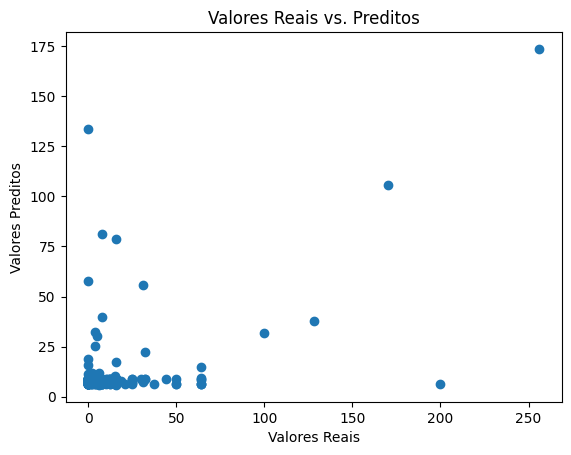

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais vs. Preditos')
plt.show()


# Com one hot encoding:

In [ ]:
pip install propythia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 29.2 MB/s eta 0:00:00


In [ ]:
from propythia.protein.encoding import Encoding

In [ ]:
dataframe_data=pd.read_csv("/content/CERTO_MIC_final_com_featuress.csv")

In [ ]:
enconde_df= Encoding(dataset= dataframe_data ,  col= 'Sequence')
enconde_df.result

,Unnamed: 0,Sequence,MIC_padronizado,length,A,R,N,D,C,E,...,VK,VM,VF,VP,VS,VT,VW,VY,VV,Cluster
0,0,VTSWSLCTPGCTSPGGGSNCSFCC,2.000000e+00,24.0,0.000,0.000,4.167,0.000,20.833,0.000,...,0.00,0.0,0.0,0.00,0.0,4.35,0.0,0.00,0.0,2
1,1,ATRSYGNGVYCNNSKCWVNWGEAKENIAGIVISGWASGLAGMGH,2.000000e-03,44.0,11.364,2.273,11.364,0.000,4.545,4.545,...,0.00,0.0,0.0,0.00,0.0,0.00,0.0,2.33,0.0,2
2,2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,5.080000e-05,40.0,2.500,0.000,7.500,2.500,5.000,0.000,...,2.56,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,2
3,3,NRWYCNSAAGGVGGAAVCGLAGYVGEAKENIAGEVRKGWGMAGGFT...,3.200000e+00,62.0,16.129,3.226,6.452,0.000,4.839,4.839,...,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,2
4,4,LIDHLGAPRWAVDTILGAIAVGNLASWVLALVPGPGWAVKAGLATA...,7.100000e-07,61.0,27.869,1.639,1.639,3.279,0.000,0.000,...,3.33,0.0,0.0,1.67,0.0,0.00,0.0,0.00,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,1007,GLLGPLLKIAAKVGSKLL,3.000000e-06,18.0,11.111,0.000,0.000,0.000,0.000,0.000,...,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0
1008,1008,GLLGKLLKIAAKVGKKLL,3.000000e-06,18.0,11.111,0.000,0.000,0.000,0.000,0.000,...,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0
1009,1009,GLLKKLLKIAAKVGKKLL,6.000000e-06,18.0,11.111,0.000,0.000,0.000,0.000,0.000,...,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0
1010,1010,GLKEVAHSAKKFAKGFISGLTGS,2.560000e-04,23.0,13.043,0.000,0.000,0.000,0.000,4.348,...,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,2


In [ ]:
res = enconde_df.get_pad_and_hot_encoding(seq_len=300)
print(len(res.iloc[0,1])) #padded sequence
print(np.array(res.iloc[0,2]).shape) #one hot encoded sequence
res

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


24
()


,Unnamed: 0,Sequence,MIC_padronizado,length,A,R,N,D,C,E,...,VF,VP,VS,VT,VW,VY,VV,Cluster,pad_seques,One_hot_encoding
0,0,VTSWSLCTPGCTSPGGGSNCSFCC,2.000000e+00,24.0,0.000,0.000,4.167,0.000,20.833,0.000,...,0.0,0.00,0.0,4.35,0.0,0.00,0.0,2,VTSWSLCTPGCTSPGGGSNCSFCCXXXXXXXXXXXXXXXXXXXXXX...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,ATRSYGNGVYCNNSKCWVNWGEAKENIAGIVISGWASGLAGMGH,2.000000e-03,44.0,11.364,2.273,11.364,0.000,4.545,4.545,...,0.0,0.00,0.0,0.00,0.0,2.33,0.0,2,ATRSYGNGVYCNNSKCWVNWGEAKENIAGIVISGWASGLAGMGHXX...,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,5.080000e-05,40.0,2.500,0.000,7.500,2.500,5.000,0.000,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILGXXXXXX...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,3,NRWYCNSAAGGVGGAAVCGLAGYVGEAKENIAGEVRKGWGMAGGFT...,3.200000e+00,62.0,16.129,3.226,6.452,0.000,4.839,4.839,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,2,NRWYCNSAAGGVGGAAVCGLAGYVGEAKENIAGEVRKGWGMAGGFT...,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,4,LIDHLGAPRWAVDTILGAIAVGNLASWVLALVPGPGWAVKAGLATA...,7.100000e-07,61.0,27.869,1.639,1.639,3.279,0.000,0.000,...,0.0,1.67,0.0,0.00,0.0,0.00,0.0,2,LIDHLGAPRWAVDTILGAIAVGNLASWVLALVPGPGWAVKAGLATA...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,1007,GLLGPLLKIAAKVGSKLL,3.000000e-06,18.0,11.111,0.000,0.000,0.000,0.000,0.000,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0,GLLGPLLKIAAKVGSKLLXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
1008,1008,GLLGKLLKIAAKVGKKLL,3.000000e-06,18.0,11.111,0.000,0.000,0.000,0.000,0.000,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0,GLLGKLLKIAAKVGKKLLXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
1009,1009,GLLKKLLKIAAKVGKKLL,6.000000e-06,18.0,11.111,0.000,0.000,0.000,0.000,0.000,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0,GLLKKLLKIAAKVGKKLLXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
1010,1010,GLKEVAHSAKKFAKGFISGLTGS,2.560000e-04,23.0,13.043,0.000,0.000,0.000,0.000,4.348,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,2,GLKEVAHSAKKFAKGFISGLTGSXXXXXXXXXXXXXXXXXXXXXXX...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."


In [ ]:
# Separando as features (X) e o target (y)
X = df_novo.drop(['MIC_padronizado'], axis=1)
y = df_novo['MIC_padronizado']

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset do artigo:

In [ ]:
mic=pd.read_csv("/content/mic_data.csv")

In [ ]:
mic

,Unnamed: 0,sequence,value
0,0,AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS,2.099950
1,1,AAAAAAAIKMLMDLVNERIMALNKKAKK,1.000000
2,2,AAAKAALNAVLVGANA,1.903090
3,3,AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC,0.250463
4,4,AAGMGFFGAR,1.108874
...,...,...,...
4541,4541,YVLWKRKRWIFI,1.778151
4542,4542,YVPLPNVPQPGRRPFPTFPGQGPFNPKIKWPQGY,0.548456
4543,4543,YVPPVQKPHPNGPKFPTFP,1.364542
4544,4544,YWKKWKKLRRIFMLV,-0.020287


In [ ]:
# Obter previsões do modelo
y_pred = model.predict(X_test).flatten()

# Converter y_test para ndarray e garantir que seja 1-dimensional
y_test = y_test.values.ravel()

# Calcular resíduos
residuos = y_test - y_pred


Vizualizar residuos:

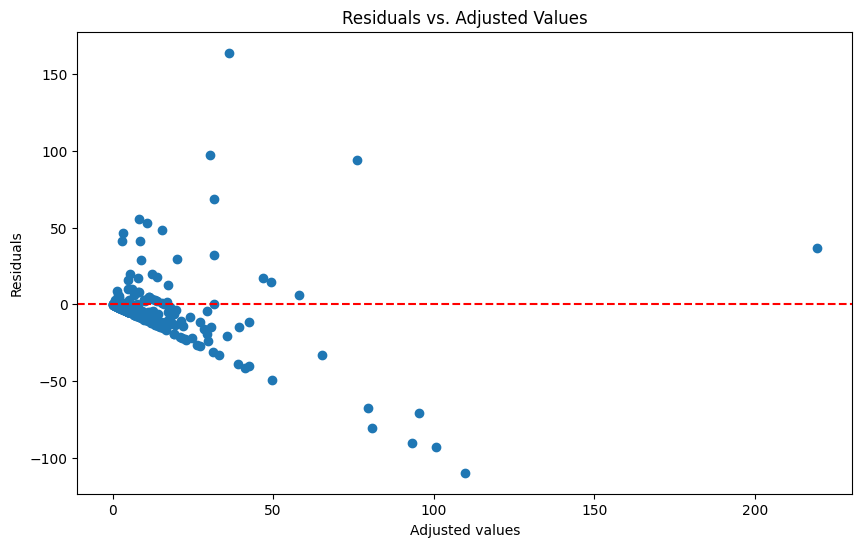

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Adjusted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Adjusted Values')
plt.show()


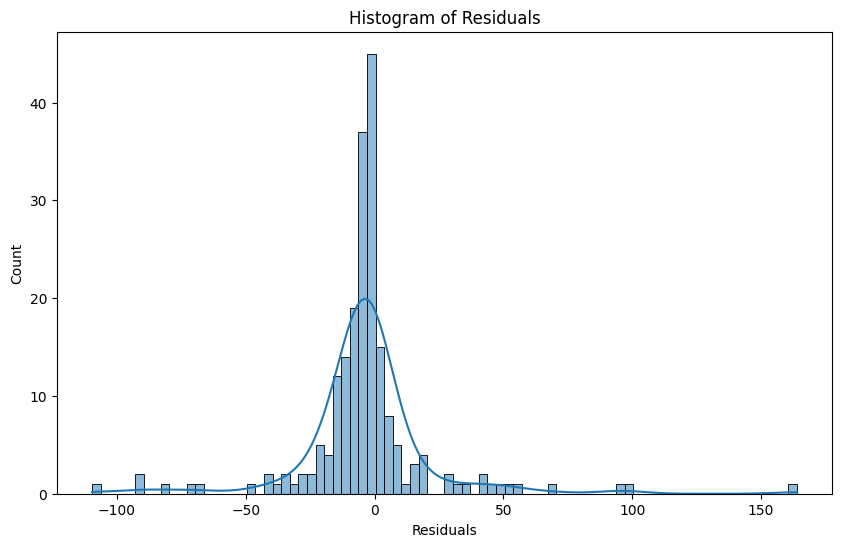

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.show()


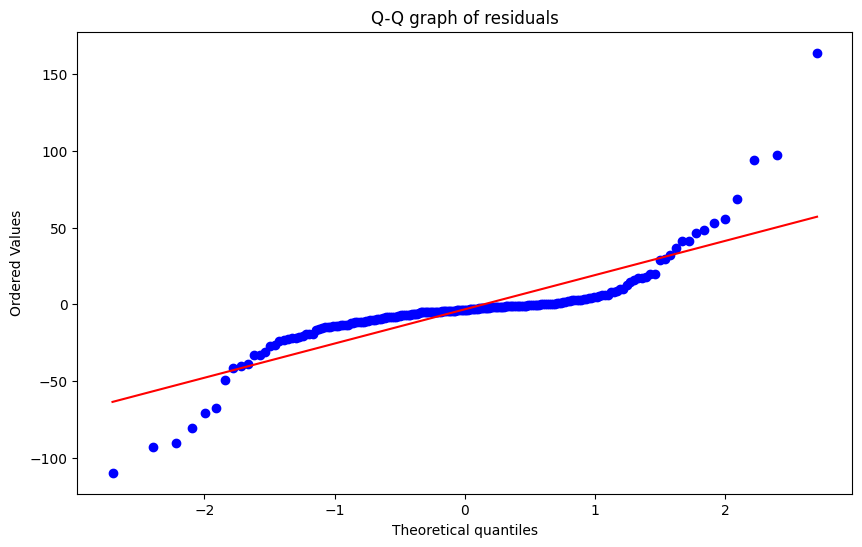

In [ ]:
plt.figure(figsize=(10, 6))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title('Q-Q graph of residuals')
plt.show()


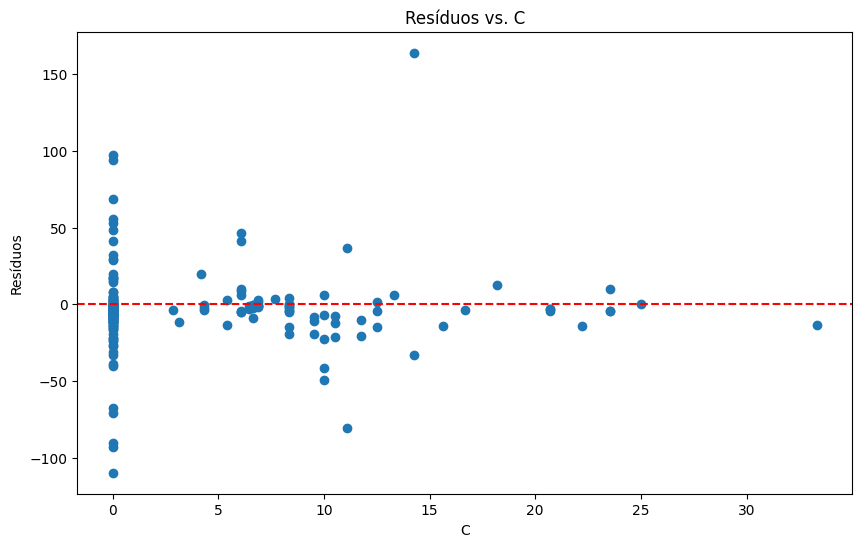

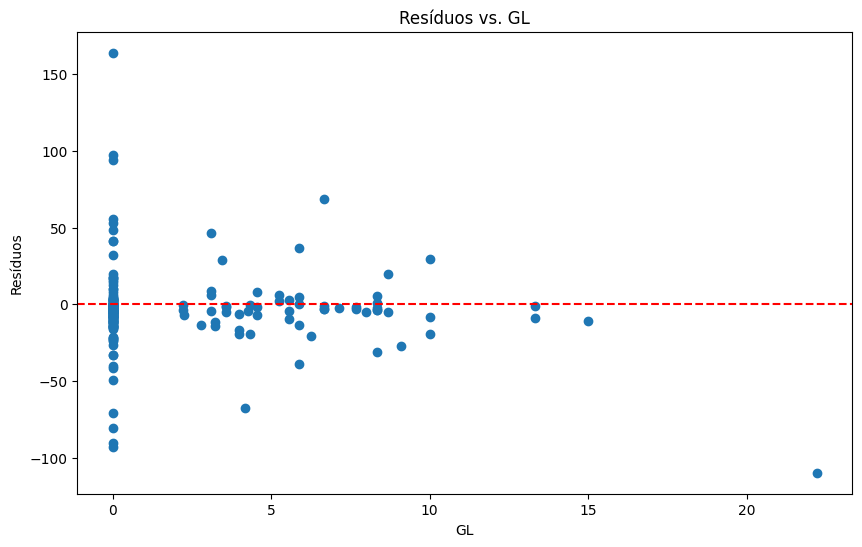

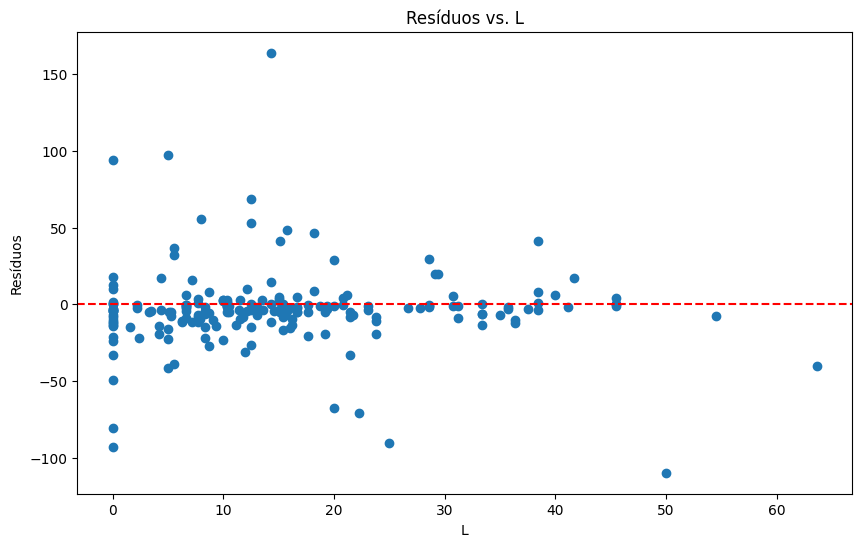

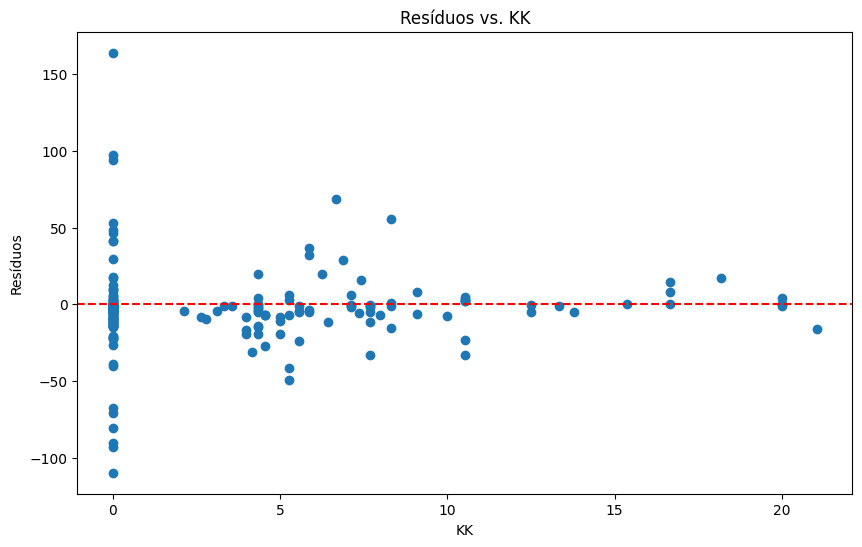

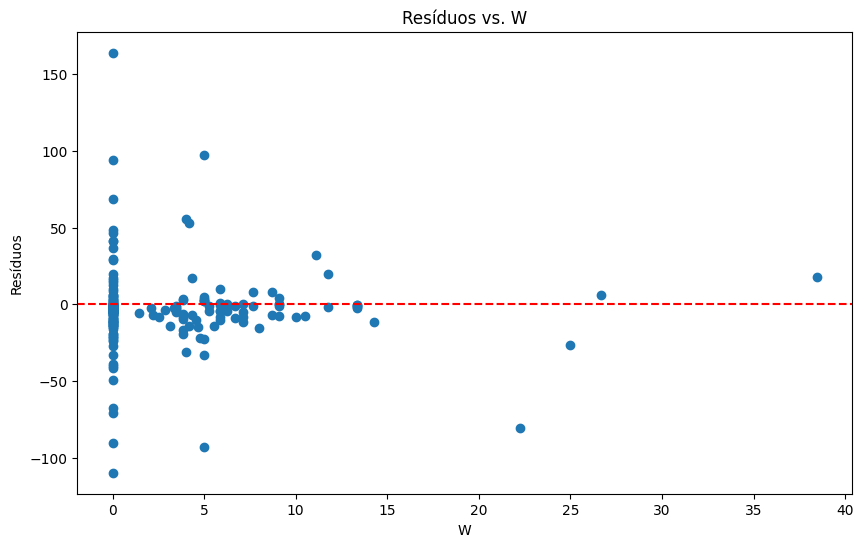

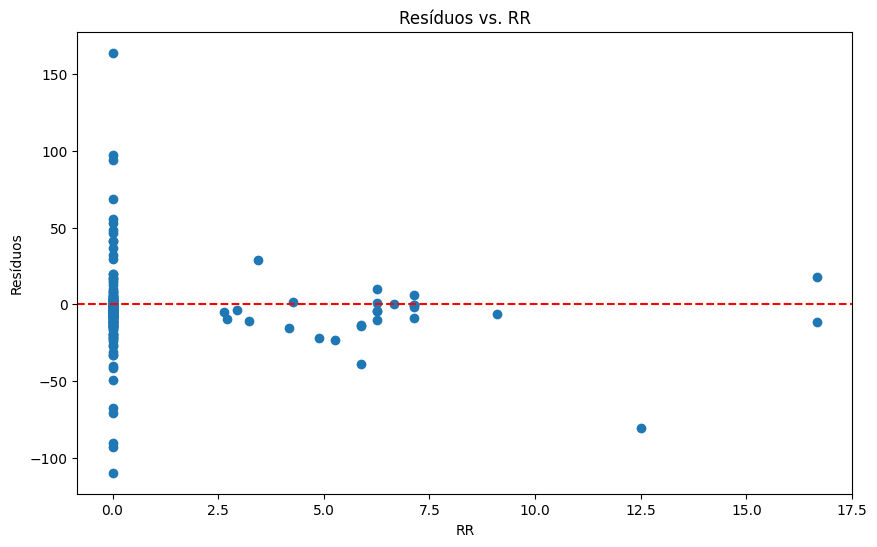

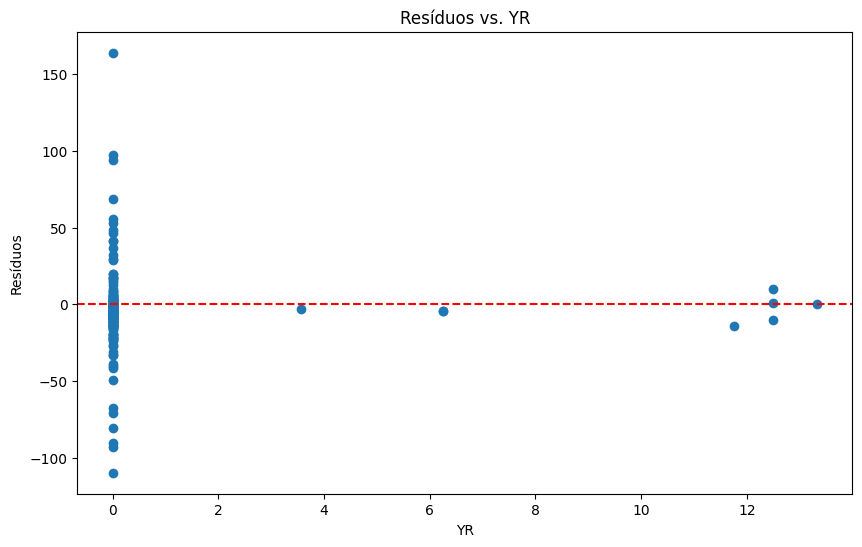

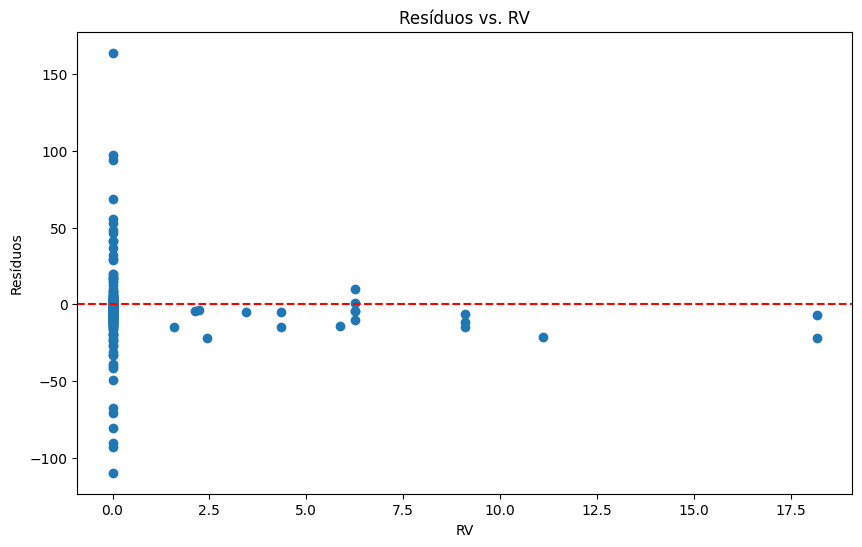

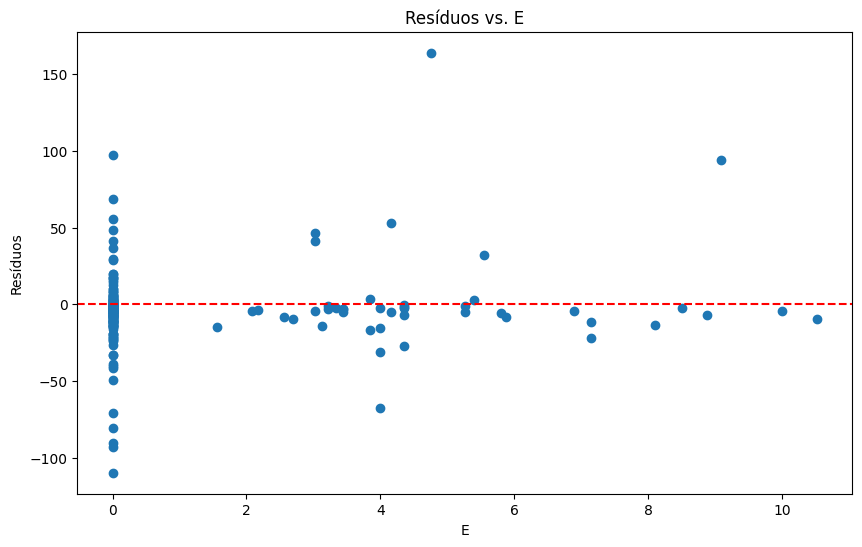

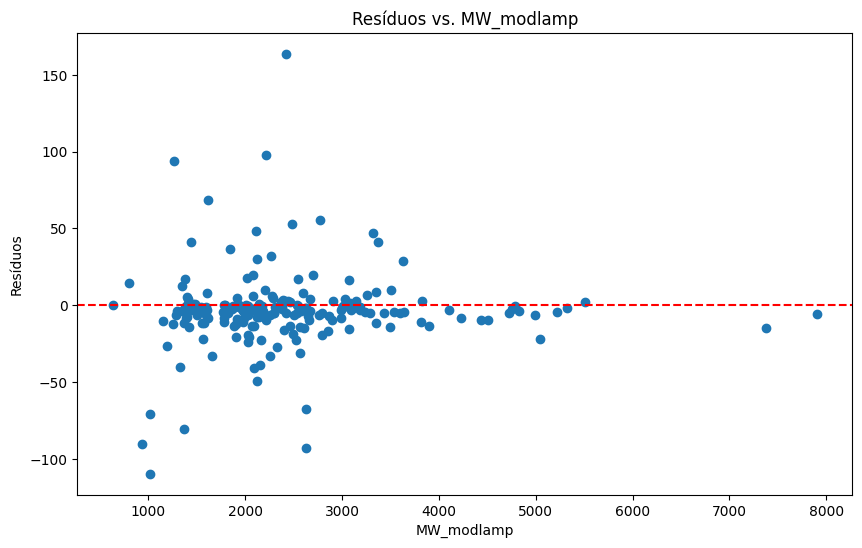

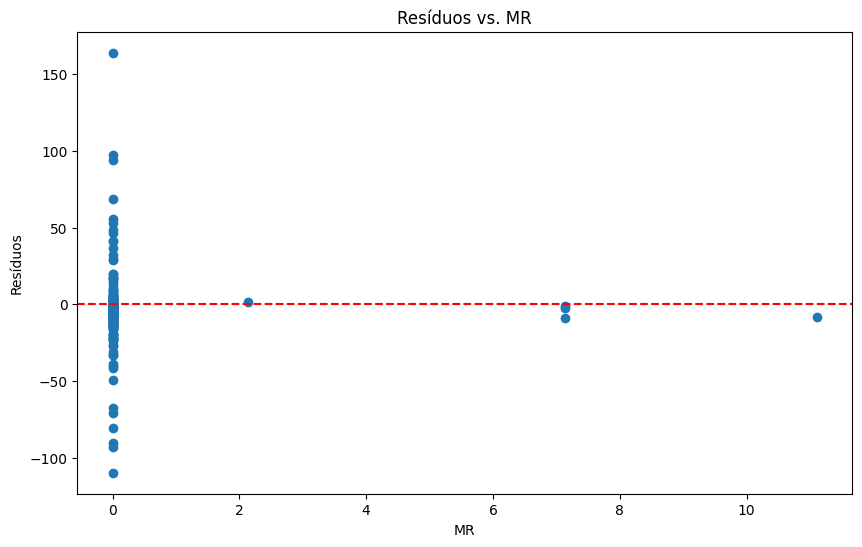

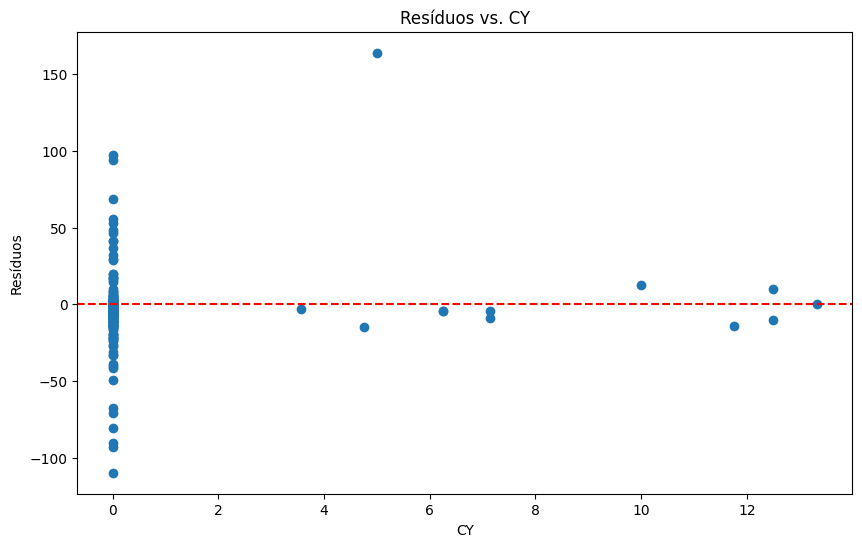

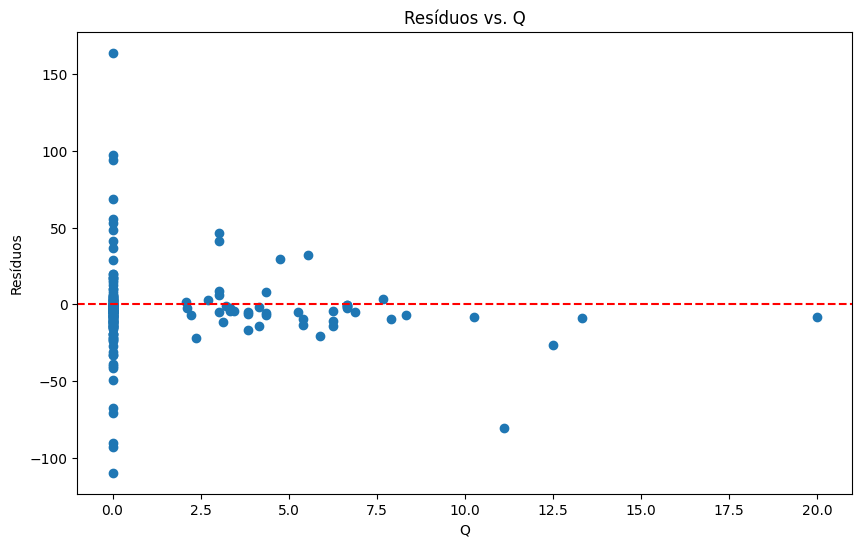

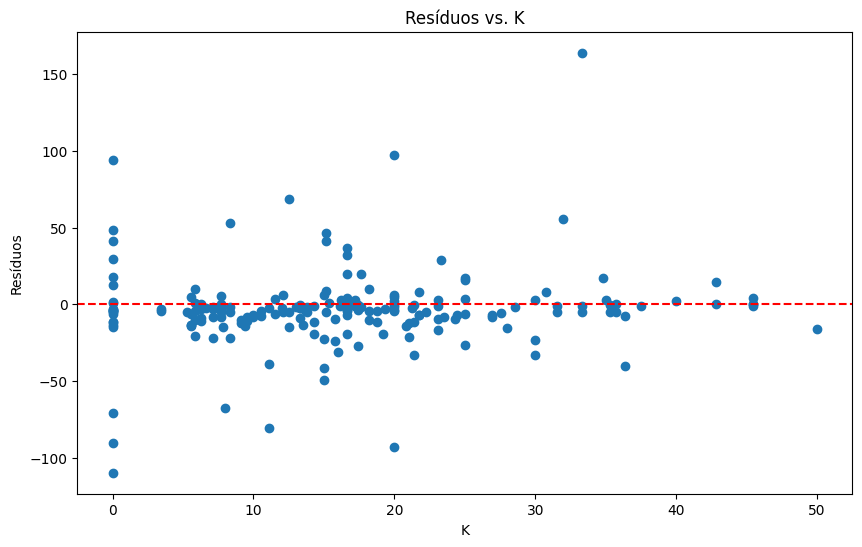

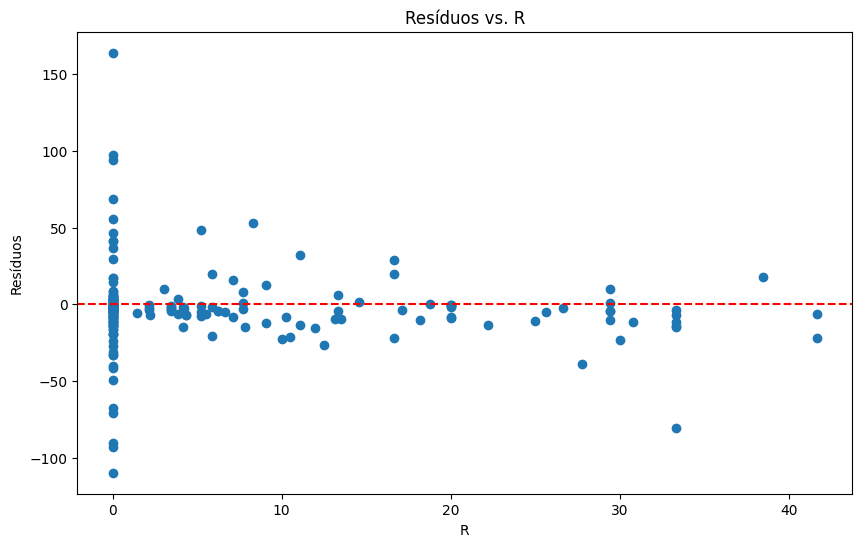

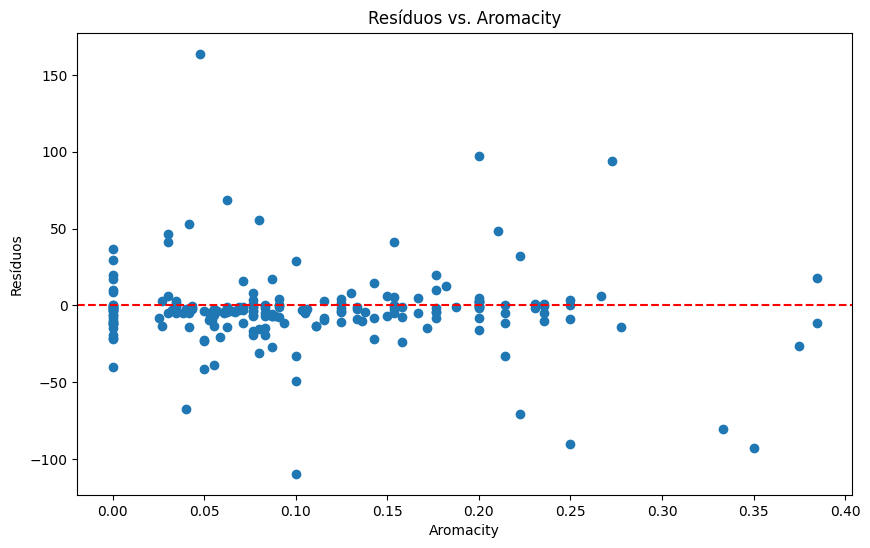

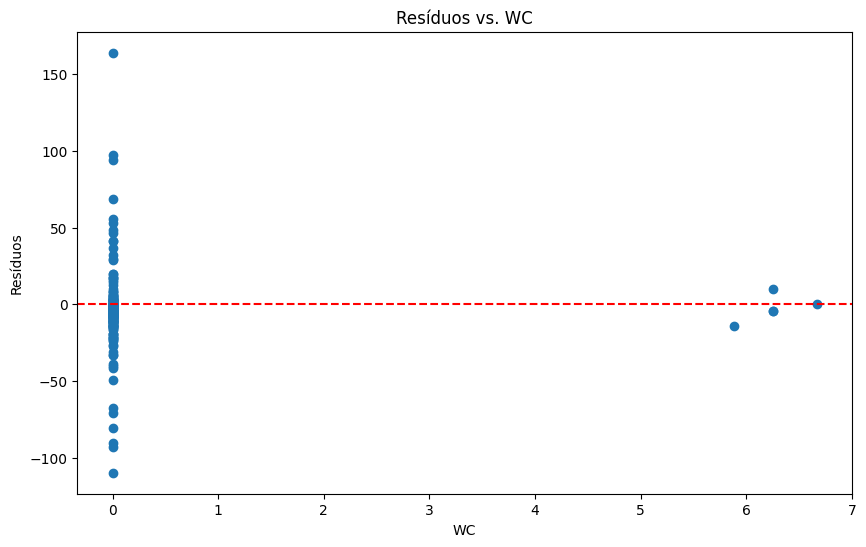

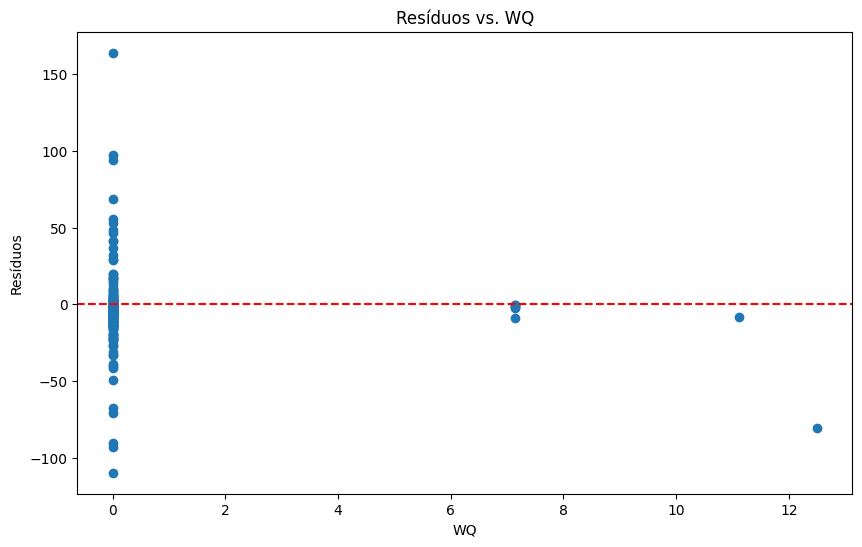

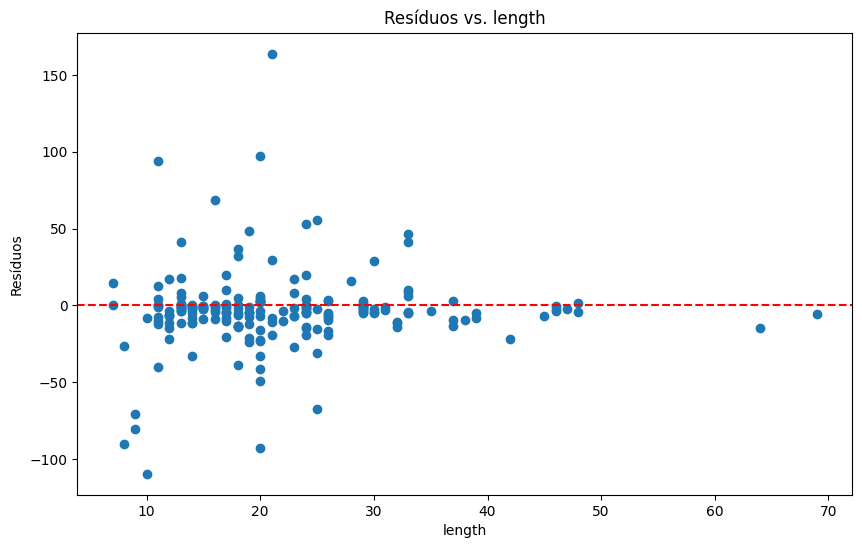

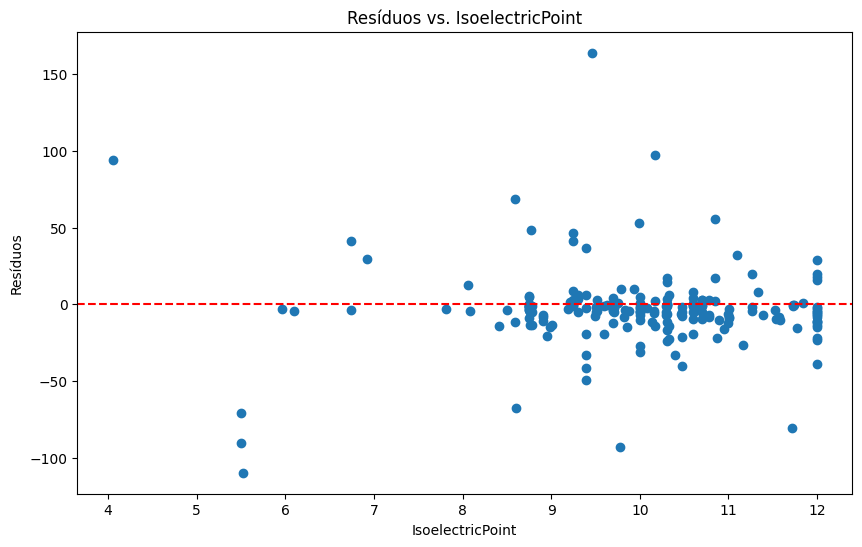

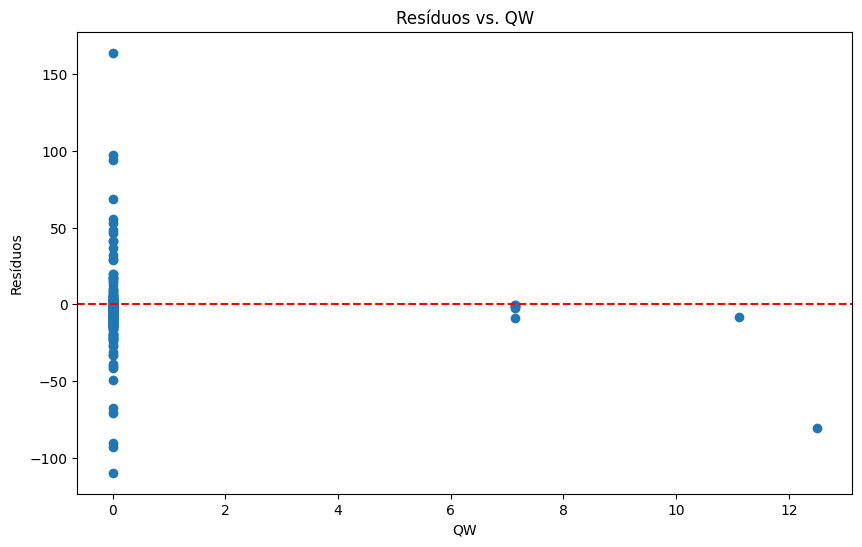

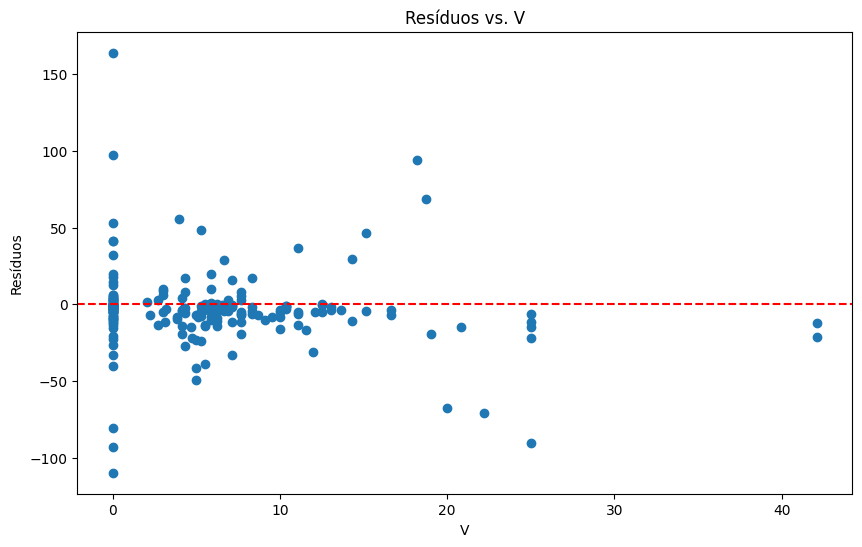

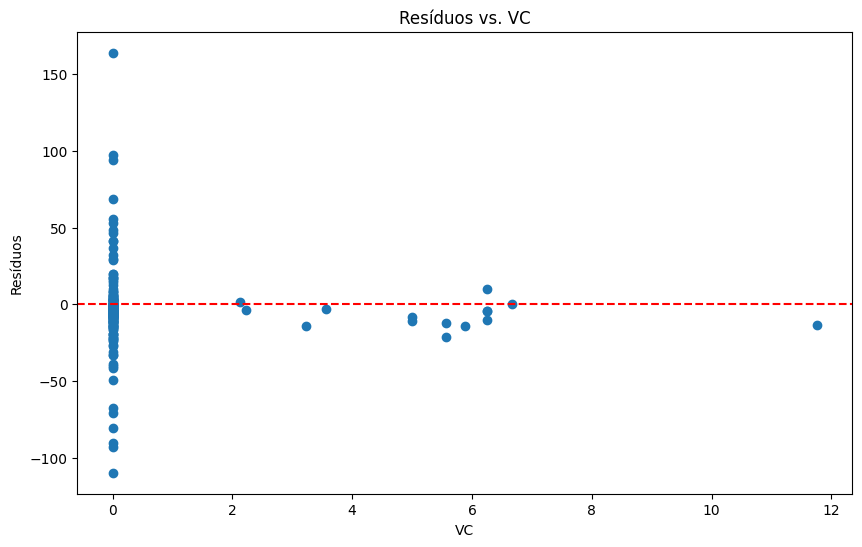

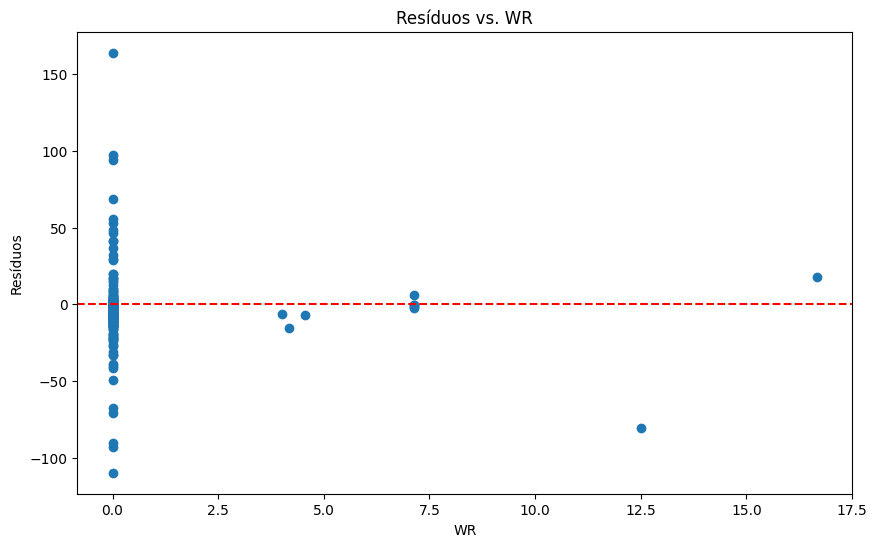

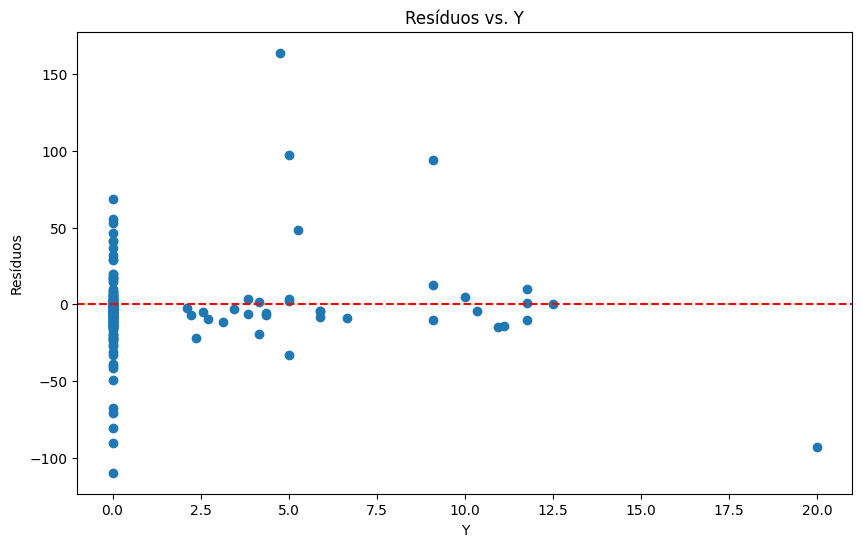

In [ ]:
X_test_df = pd.DataFrame(X_test)  # Converta X_test para um DataFrame
for col in X_test_df.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test_df[col], residuos)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(col)
    plt.ylabel('Resíduos')
    plt.title(f'Resíduos vs. {col}')
    plt.show()


Identificação de Outliers e Pontos Influentes

<ipython-input-62-9e41265891b3>:16: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", use_line_collection=True)


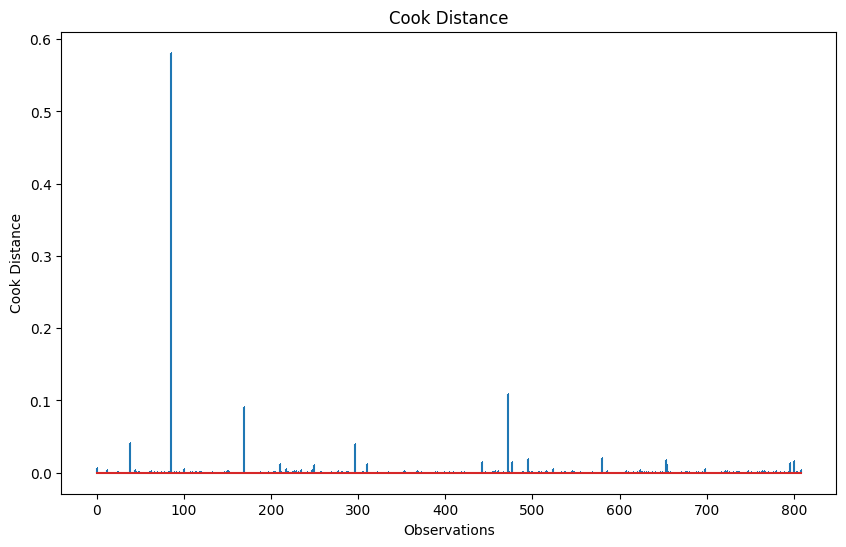

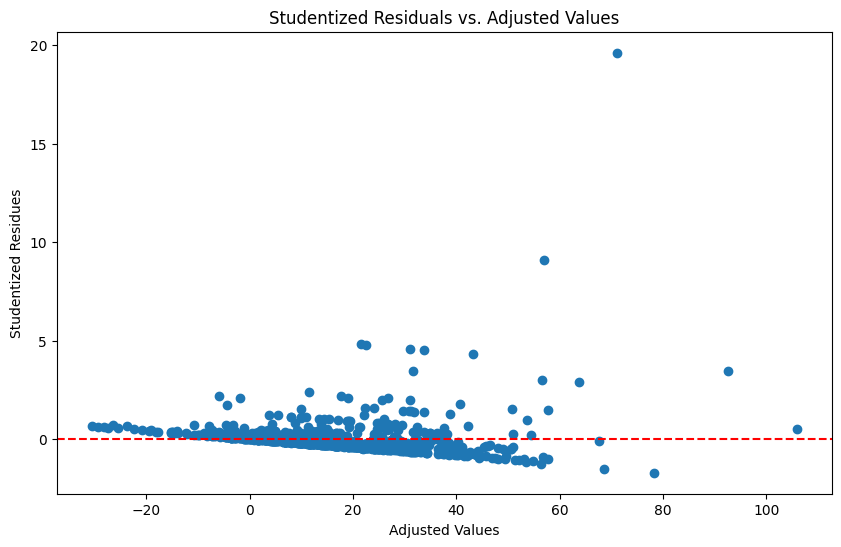

In [ ]:
import statsmodels.api as sm

# Converta X_train para DataFrame, se ainda não estiver
X_train_df = pd.DataFrame(X_train)
X_train_df = sm.add_constant(X_train_df)  # Adicione uma constante

# Ajuste o modelo OLS
ols_model = sm.OLS(y_train, X_train_df).fit()

# Calcular influências
influence = ols_model.get_influence()

# Distância de Cook
cooks_d = influence.cooks_distance[0]
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", use_line_collection=True)
plt.xlabel('Observations')
plt.ylabel("Cook Distance")
plt.title('Cook Distance')
plt.show()

# Resíduos Studentizados
residuos_studentizados = influence.resid_studentized_internal
plt.figure(figsize=(10, 6))
plt.scatter(ols_model.fittedvalues, residuos_studentizados)
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel('Adjusted Values')
plt.ylabel('Studentized Residues')
plt.title('Studentized Residuals vs. Adjusted Values')
plt.show()


In [ ]:
# Identificar outliers
outliers = np.abs(residuos_studentizados) > 2
outlier_indices = np.where(outliers)[0]

print("Índices dos Outliers:", outlier_indices)
print("Resíduos Studentizados dos Outliers:", residuos_studentizados[outliers])


Índices dos Outliers: [  0  12  38  85 169 217 235 249 297 442 472 477 495 515 523 795 800]
Resíduos Studentizados dos Outliers: [ 2.3839226   2.18673238  2.91727469 19.61781728  4.84065841  2.08709581
  2.16627554  4.51924449  3.46006839  3.45110433  9.09972042  4.33742805
  2.97529343  2.05597771  2.07020819  4.77103841  4.58521216]


eleminar outliers:

tratar dos residuos:

In [ ]:
import numpy as np

# Aplicar transformação logarítmica
y_train_transformed = np.log1p(y_train)
y_test_transformed = np.log1p(y_test)



In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Ajustar o modelo de floresta com os dados transformados
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train_transformed)


RandomForestRegressor(random_state=42)

In [ ]:
# Fazer previsões com o modelo ajustado
y_pred_transformed = model.predict(X_test)

# Reverter a transformação logarítmica para obter as previsões na escala original
y_pred = np.expm1(y_pred_transformed)

# Reverter a transformação dos dados de teste para a escala original
y_test_original = np.expm1(y_test_transformed)


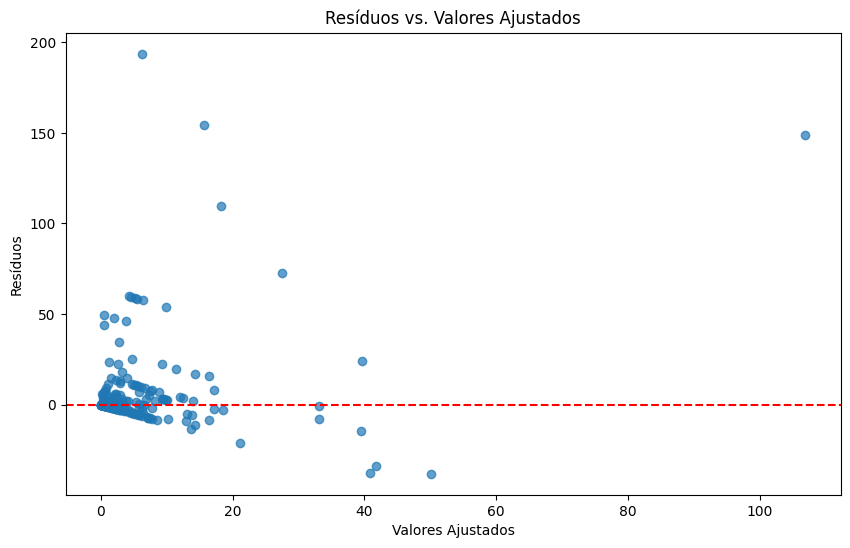

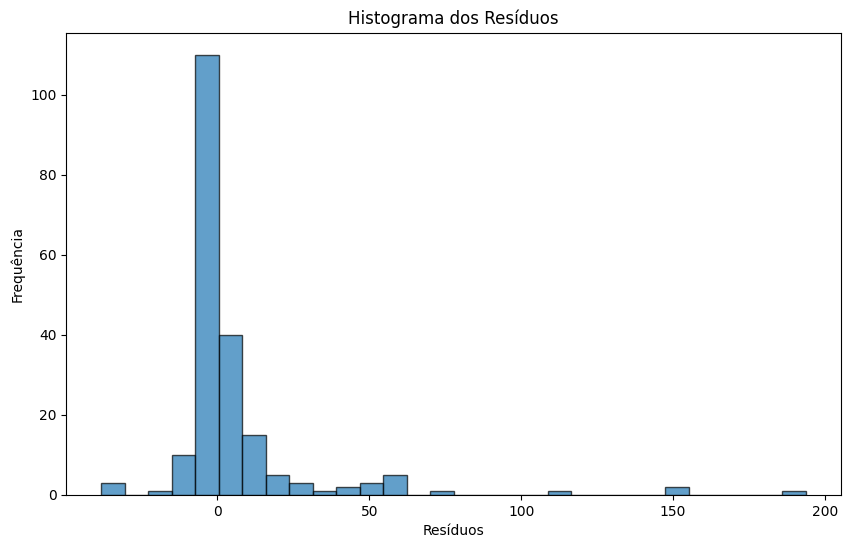

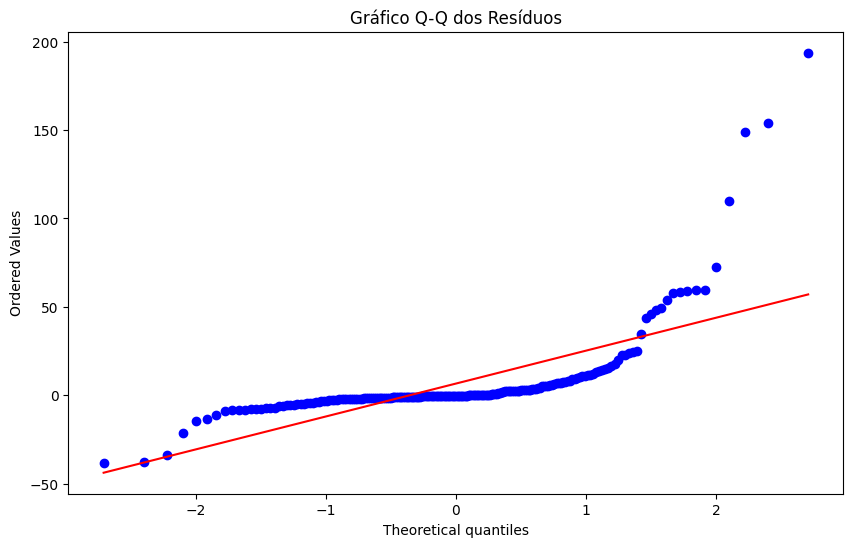

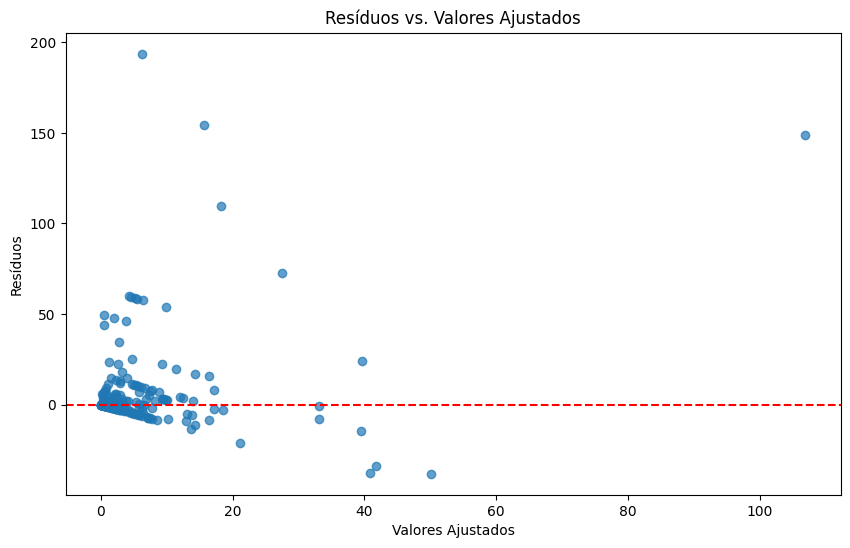

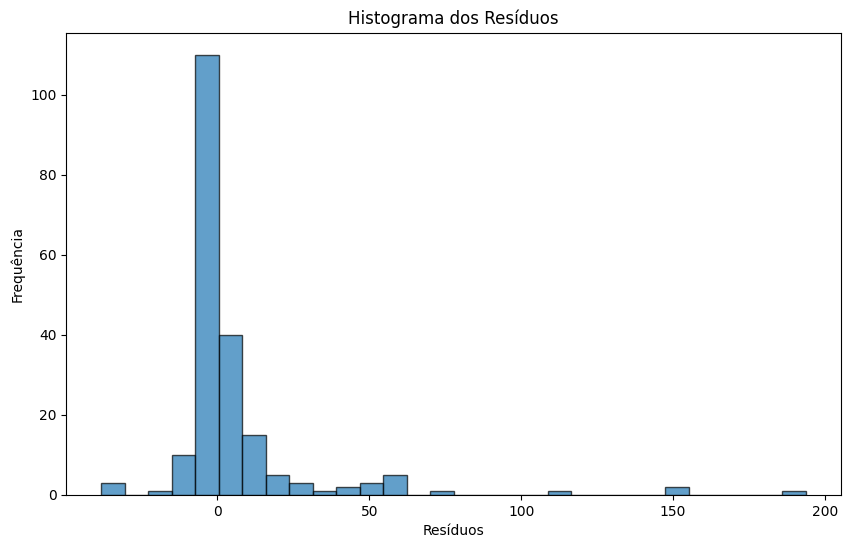

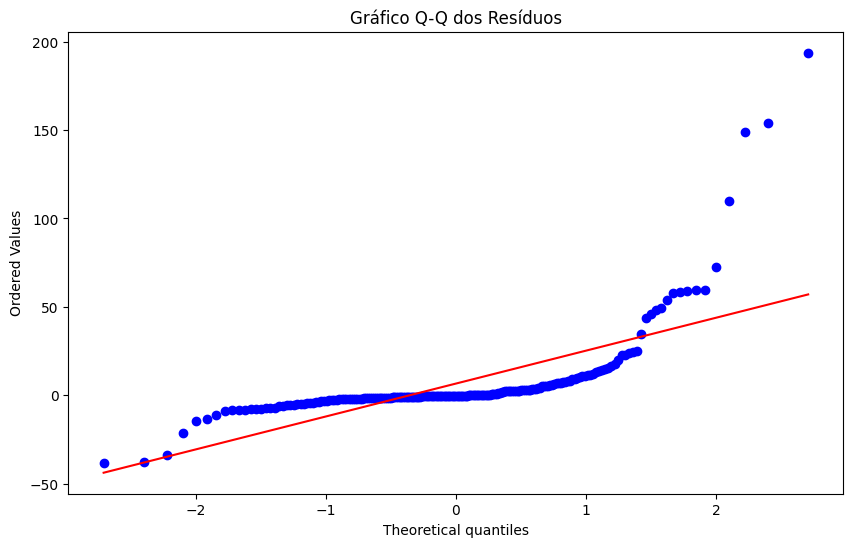

In [ ]:
# Calcular os resíduos
residuos = y_test_original - y_pred

# Gráfico de Resíduos vs. Valores Ajustados
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Valores Ajustados')
plt.show()

# Histograma dos Resíduos
plt.figure(figsize=(10, 6))
plt.hist(residuos, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Histograma dos Resíduos')
plt.show()

# Gráfico Q-Q dos Resíduos
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title('Gráfico Q-Q dos Resíduos')
plt.show()


In [ ]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train_transformed)


DecisionTreeRegressor(random_state=42)

In [ ]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
model.fit(X_train, y_train_transformed)


MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

In [ ]:
import statsmodels.api as sm

# Ajustar um modelo robusto
robust_model = sm.RLM(y_train_transformed, sm.add_constant(X_train), M=sm.robust.norms.HuberT()).fit()


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Adicionar termos polinomiais às variáveis independentes
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Ajustar o modelo com dados polinomiais
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_poly, y_train_transformed)


RandomForestRegressor(random_state=42)

# FORWARD SELECTION

In [ ]:
pip install numpy pandas statsmodels


In [ ]:
data=pd.read_csv("/content/MIC_final_com_featuress.csv")

In [ ]:
data

,Sequence,Name,Target_Organism,Function,MIC_padronizado,length,A,R,N,D,...,VL,VK,VM,VF,VP,VS,VT,VW,VY,VV
0,VTSWSLCTPGCTSPGGGSNCSFCC,Microbisporicin A1 (Bacteriocin),L Enterococcus faecium,antibacterian group ESKAPE,2.000000e+00,24.0,0.000,0.000,4.167,0.000,...,0.00,0.00,0.0,0.0,0.00,0.0,4.35,0.0,0.00,0.0
1,ATRSYGNGVYCNNSKCWVNWGEAKENIAGIVISGWASGLAGMGH,Enterocin P (Pediocin-like peptide; Bacteriocin),Enterococcus faecium,antibacterian group ESKAPE,2.000000e-03,44.0,11.364,2.273,11.364,0.000,...,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,2.33,0.0
2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,Enterocin X alpha (Two-peptide bacteriocin),Enterococcus faecium 1344L,antibacterian group ESKAPE,5.080000e-05,40.0,2.500,0.000,7.500,2.500,...,0.00,2.56,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0
3,NRWYCNSAAGGVGGAAVCGLAGYVGEAKENIAGEVRKGWGMAGGFT...,Enterocin E-760 (Bacteriocin),Klebsiella pneumoniae,antibacterian group ESKAPE,3.200000e+00,62.0,16.129,3.226,6.452,0.000,...,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0
4,LIDHLGAPRWAVDTILGAIAVGNLASWVLALVPGPGWAVKAGLATA...,Lactocyclicin Q (Bacteriocin),Enterococcus faecium,antibacterian group ESKAPE,7.100000e-07,61.0,27.869,1.639,1.639,3.279,...,1.67,3.33,0.0,0.0,1.67,0.0,0.00,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,GLLGPLLKIAAKVGSKLL,XT-7 [N16K],Staphylococcus aureus,antibacterian group ESKAPE,3.000000e-06,18.0,11.111,0.000,0.000,0.000,...,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0
1008,GLLGKLLKIAAKVGKKLL,"XT-7 [P5K,S15K,N16K]",Staphylococcus aureus,antibacterian group ESKAPE,3.000000e-06,18.0,11.111,0.000,0.000,0.000,...,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0
1009,GLLKKLLKIAAKVGKKLL,"XT-7 [G4K,P5K,S15K,N16K]",Staphylococcus aureus,antibacterian group ESKAPE,6.000000e-06,18.0,11.111,0.000,0.000,0.000,...,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0
1010,GLKEVAHSAKKFAKGFISGLTGS,Pxt‐3,Pseudomonas aeruginosa,antibacterian group ESKAPE,2.560000e-04,23.0,13.043,0.000,0.000,0.000,...,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0


In [ ]:
data.drop(columns=["Name","Target_Organism","Function"], inplace=True)

In [ ]:
# Suponha que a variável dependente seja 'target' e todas as outras são independentes
X = data.drop(columns=['MIC_padronizado',"Sequence"])  # Variáveis independentes
y = data['MIC_padronizado']               # Variável dependente


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Inicializar o escalonador Min-Max
scaler = MinMaxScaler()

# Ajustar e transformar os dados
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

forward selection

In [ ]:
def forward_selection(X, y):
    initial_features = []
    remaining_features = list(X.columns)
    best_features = []

    while remaining_features:
        best_r2 = 0
        best_feature = None
        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[initial_features + [feature]])).fit()
            r2 = model.rsquared
            if r2 > best_r2:
                best_r2 = r2
                best_feature = feature

        if best_feature is not None:
            initial_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_features.append(best_feature)
        else:
            break

    return best_features

# Executar a seleção de variáveis com os dados normalizados
selected_features = forward_selection(X_normalized, y)
print(f"Selected features: {selected_features}")


Selected features: ['EF', 'MI', 'TD', 'ME', 'GY', 'MW_modlamp', 'GW', 'FY', 'DS', 'FV', 'IV', 'DF', 'PA', 'SS', 'YM', 'DA', 'WK', 'LM', 'SV', 'VE', 'YA', 'DP', 'ED', 'WV', 'VW', 'WG', 'VQ', 'PI', 'YC', 'IC', 'RC', 'DM', 'KA', 'EG', 'IK', 'AP', 'ER', 'VG', 'HY', 'QA', 'SG', 'GL', 'NL', 'TY', 'ES', 'LW', 'GD', 'TE', 'GR', 'RP', 'VP', 'YW', 'DR', 'YK', 'LG', 'YN', 'FW', 'GE', 'TV', 'FF', 'TF', 'MG', 'TI', 'KQ', 'HR', 'VT', 'NA', 'IM', 'IF', 'NW', 'ND', 'LC', 'FG', 'NC', 'HK', 'YE', 'WF', 'EP', 'KI', 'CK', 'TG', 'FN', 'CW', 'DW', 'PK', 'LA', 'WI', 'WY', 'TM', 'YI', 'DG', 'AW', 'WW', 'PW', 'KV', 'VK', 'VF', 'AE', 'YS', 'VS', 'NY', 'IR', 'ST', 'VI', 'IW', 'CM', 'PD', 'RE', 'MY', 'EL', 'EY', 'YF', 'SY', 'RI', 'DC', 'WD', 'KW', 'LK', 'NG', 'TK', 'DH', 'MS', 'FD', 'AR', 'VV', 'SW', 'RS', 'RN', 'KK', 'AF', 'WP', 'PR', 'WS', 'TA', 'EW', 'KY', 'YG', 'TT', 'WL', 'CE', 'CC', 'AK', 'LD', 'V', 'HE', 'GG', 'length', 'AQ', 'SH', 'AI', 'MF', 'AT', 'HC', 'KH', 'HM', 'SL', 'NQ', 'GC', 'IQ', 'NN', 'AY', 'YR

# Using protbert results:

In [ ]:
embedding=pd.read_csv("/content/MIC_ESKAPE_Protbert.csv")

In [ ]:
embedding

,Sequence,MIC_padronizado,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,...,PC_41,PC_42,PC_43,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50
0,VTSWSLCTPGCTSPGGGSNCSFCC,2.000000e+00,-0.493979,-0.155868,-0.555815,-0.056548,-0.010042,-0.316944,0.285729,-0.275770,...,-0.012891,0.083928,-0.058959,0.073833,0.091425,0.160858,-0.110719,0.113342,-0.107551,-0.034205
1,ATRSYGNGVYCNNSKCWVNWGEAKENIAGIVISGWASGLAGMGH,2.000000e-03,-0.174698,-0.346400,-0.368407,-0.394889,0.010364,-0.384787,0.180413,-0.109989,...,0.038083,-0.018262,0.027933,-0.043522,0.029086,0.021981,0.007420,0.046657,-0.062074,0.043112
2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,5.080000e-05,-0.383691,-0.698315,-0.105476,-0.034654,0.036367,-0.438417,0.169066,-0.259540,...,0.001967,0.027157,0.008440,-0.044323,-0.019911,-0.036539,0.046362,0.012207,-0.030038,0.023548
3,NRWYCNSAAGGVGGAAVCGLAGYVGEAKENIAGEVRKGWGMAGGFT...,3.200000e+00,0.219249,-0.071223,-0.555025,-0.392385,-0.042080,-0.183163,0.122867,0.062682,...,0.053979,-0.028171,0.067804,-0.040205,0.010687,-0.017881,0.051783,0.014638,-0.042955,0.052354
4,LIDHLGAPRWAVDTILGAIAVGNLASWVLALVPGPGWAVKAGLATA...,7.100000e-07,0.445736,0.004909,-0.988600,-0.219642,-0.467911,0.136723,0.149340,-0.190966,...,0.010433,-0.021122,0.010963,0.019786,0.004229,0.003218,0.037833,0.122643,-0.055195,0.108244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,GLLKKLLKIAAKVGKKLL,6.000000e-06,1.095988,0.214445,-0.077592,0.356635,-0.185000,0.099447,-0.069444,0.249694,...,-0.003937,-0.137605,-0.016557,0.032790,-0.005687,0.076925,-0.017712,-0.010141,-0.009296,-0.019409
1901,GLKEVAHSAKKFAKGFISGLTGS,2.560000e-04,1.383715,0.067696,-0.106215,-0.185514,-0.005729,0.041064,-0.114845,0.067231,...,0.029104,-0.007854,0.036291,0.018595,0.049974,0.006211,0.036348,0.003200,0.063827,-0.000008
1902,GLKEVAHSAKKFAKGFISGLTGS,2.560000e-04,1.383715,0.067696,-0.106215,-0.185514,-0.005729,0.041064,-0.114845,0.067231,...,0.029104,-0.007854,0.036291,0.018595,0.049974,0.006211,0.036348,0.003200,0.063827,-0.000008
1903,NLLGSLLKTGLKVGSNLL,2.560000e-04,1.627001,0.683238,-0.070153,0.734653,0.530262,-0.144001,-0.198102,0.225417,...,0.080966,0.006864,0.107715,0.096003,0.007784,-0.037234,-0.054666,0.034086,0.027811,0.062402


In [ ]:
from sklearn.preprocessing import StandardScaler

# Separando as features (X) e o target (y)
X = embedding.drop(['MIC_padronizado',"Sequence"], axis=1)
y = embedding['MIC_padronizado']

In [ ]:
# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Padronizando as características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Logist

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Treinando o modelo de regressão com RandomForest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

print(f'R^2 Score: {r2}') # MEU

Mean Squared Error: 6513.019914003727
R^2 Score: 0.08862372445072164
R^2 Score: 0.08862372445072164


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [ ]:
# Função para avaliar o modelo
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    return mse, r2

# Random Forest
print("Random Forest")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
evaluate_model(rf, X_train, X_test, y_train, y_test)

# Gradient Boosting
print("Gradient Boosting")
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
evaluate_model(gb, X_train, X_test, y_train, y_test)

# Ridge Regression
print("Ridge Regression")
ridge = Ridge(alpha=1.0)
evaluate_model(ridge, X_train, X_test, y_train, y_test)

# Elastic Net
print("Elastic Net")
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5)
evaluate_model(elastic_net, X_train, X_test, y_train, y_test)

# Rede Neural Simples
print("Rede Neural Simples")
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
y_pred_nn = model.predict(X_test)
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print(f'Mean Squared Error: {mse_nn}')
print(f'R^2 Score: {r2_nn}')

Random Forest
Mean Squared Error: 6513.019914003727
R^2 Score: 0.08862372445072164
Gradient Boosting
Mean Squared Error: 6475.203131971764
R^2 Score: 0.09391548133410599
Ridge Regression
Mean Squared Error: 7073.430952843742
R^2 Score: 0.010204599052908048
Elastic Net
Mean Squared Error: 7144.758565032137
R^2 Score: 0.0002236233460302106
Rede Neural Simples


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1803.5826
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2094.9236
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1606.1494
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1613.1854
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1383.6871
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1809.5352
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1744.8920
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1980.1790
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1859.9327
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1768.1941
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1237.9427
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1431.2222
Epoch 13/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1578.1621
Epoch 14/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1721.9799
Epoch 15/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Definir o modelo
gb = GradientBoostingRegressor(random_state=42)

# Definir a grade de hiperparâmetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Configurar a busca em grade
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Ajustar o modelo
grid_search.fit(X_train, y_train)

# Melhor conjunto de hiperparâmetros
print("Melhores hiperparâmetros:", grid_search.best_params_)

# Avaliar o modelo com os melhores hiperparâmetros
best_gb = grid_search.best_estimator_
evaluate_model(best_gb, X_train, X_test, y_train, y_test)


Melhores hiperparâmetros: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Mean Squared Error: 6343.551877563598
R^2 Score: 0.11233763135024932


(6343.551877563598, 0.11233763135024932)

rede neuronal profunda

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Definir a arquitetura da rede neural profunda
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinar o modelo
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Avaliar o modelo
y_pred_nn = model.predict(X_test)
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print(f'Mean Squared Error: {mse_nn}')
print(f'R^2 Score: {r2_nn}')

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1595.7574 - val_loss: 1938.6438
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1817.5197 - val_loss: 1794.0713
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1875.8430 - val_loss: 1760.9424
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1316.5848 - val_loss: 1717.7882
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1349.3102 - val_loss: 1690.5916
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1947.1897 - val_loss: 1685.3557
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1873.9099 - val_loss: 1655.8984
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1009.2881 - val_loss: 1625.5144
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1270.7617 - val_loss: 1603.2527
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1450.8788 - val_loss: 1568.5747
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1799.3955 - val_loss: 1574.0077
Epoch 12

Lidar com o meu dataset:

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

# Carregar os dados (substitua 'seu_arquivo.csv' pelo nome do seu arquivo)
df = pd.read_csv('/content/CERTO_MIC_final_com_featuress.csv')



In [ ]:
df

,Unnamed: 0,Sequence,MIC_padronizado,length,A,R,N,D,C,E,...,VK,VM,VF,VP,VS,VT,VW,VY,VV,Cluster
0,0,VTSWSLCTPGCTSPGGGSNCSFCC,2.000000e+00,24.0,0.000,0.000,4.167,0.000,20.833,0.000,...,0.00,0.0,0.0,0.00,0.0,4.35,0.0,0.00,0.0,2
1,1,ATRSYGNGVYCNNSKCWVNWGEAKENIAGIVISGWASGLAGMGH,2.000000e-03,44.0,11.364,2.273,11.364,0.000,4.545,4.545,...,0.00,0.0,0.0,0.00,0.0,0.00,0.0,2.33,0.0,2
2,2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,5.080000e-05,40.0,2.500,0.000,7.500,2.500,5.000,0.000,...,2.56,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,2
3,3,NRWYCNSAAGGVGGAAVCGLAGYVGEAKENIAGEVRKGWGMAGGFT...,3.200000e+00,62.0,16.129,3.226,6.452,0.000,4.839,4.839,...,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,2
4,4,LIDHLGAPRWAVDTILGAIAVGNLASWVLALVPGPGWAVKAGLATA...,7.100000e-07,61.0,27.869,1.639,1.639,3.279,0.000,0.000,...,3.33,0.0,0.0,1.67,0.0,0.00,0.0,0.00,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,1007,GLLGPLLKIAAKVGSKLL,3.000000e-06,18.0,11.111,0.000,0.000,0.000,0.000,0.000,...,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0
1008,1008,GLLGKLLKIAAKVGKKLL,3.000000e-06,18.0,11.111,0.000,0.000,0.000,0.000,0.000,...,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0
1009,1009,GLLKKLLKIAAKVGKKLL,6.000000e-06,18.0,11.111,0.000,0.000,0.000,0.000,0.000,...,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0
1010,1010,GLKEVAHSAKKFAKGFISGLTGS,2.560000e-04,23.0,13.043,0.000,0.000,0.000,0.000,4.348,...,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,2


In [ ]:
df.drop(columns="Unnamed: 0", inplace= True)

In [ ]:
# Supondo que 'X' seja a matriz de features e 'y' a variável target
X = df.drop(columns=['Sequence','MIC_padronizado'])
y = df['MIC_padronizado']

In [ ]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Crie o escalador
scaler = StandardScaler()

# Ajuste e transforme os dados de treinamento
X_train_scaled = scaler.fit_transform(X_train)

# Transforme os dados de teste
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Ajustar um modelo linear inicial
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Previsões e resíduos
y_pred = model.predict(X_train_scaled)
residuals = y_train - y_pred

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


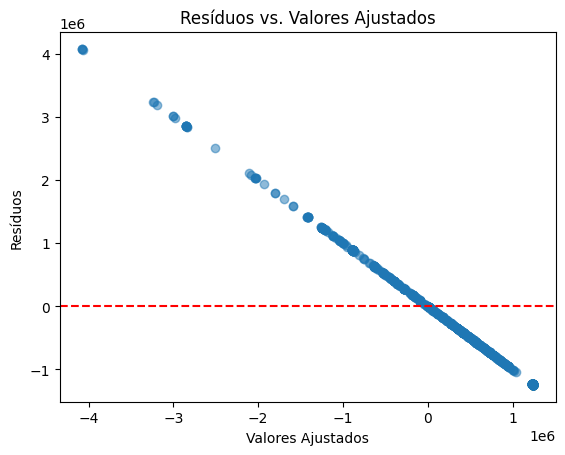

In [ ]:
# Plotar resíduos vs valores ajustados
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Valores Ajustados')
plt.show()

In [ ]:
# Análise de Outliers (pontos com resíduos grandes)
outliers = X_train[np.abs(residuals) > 3*np.std(residuals)]
print("Outliers:\n", outliers)

Outliers:
      length       A       R    N    D       C    E    Q       G    H  ...  \
898    13.0   0.000  15.385  0.0  0.0   0.000  0.0  0.0   0.000  0.0  ...   
572    10.0   0.000  50.000  0.0  0.0   0.000  0.0  0.0   0.000  0.0  ...   
834    13.0   0.000  30.769  0.0  0.0   0.000  0.0  0.0  15.385  0.0  ...   
835    13.0  15.385  30.769  0.0  0.0   0.000  0.0  0.0   0.000  0.0  ...   
575    10.0   0.000  50.000  0.0  0.0   0.000  0.0  0.0   0.000  0.0  ...   
423    13.0  23.077  15.385  0.0  0.0   0.000  0.0  0.0   0.000  0.0  ...   
901    13.0   0.000  15.385  0.0  0.0   0.000  0.0  0.0   0.000  0.0  ...   
902    13.0   0.000  15.385  0.0  0.0   0.000  0.0  0.0   0.000  0.0  ...   
692    19.0   0.000   0.000  0.0  0.0  10.526  0.0  0.0  10.526  0.0  ...   
868    13.0   0.000  15.385  0.0  0.0   0.000  0.0  0.0   0.000  0.0  ...   
229    10.0   0.000  10.000  0.0  0.0   0.000  0.0  0.0  10.000  0.0  ...   
950    20.0  15.000   0.000  5.0  0.0   0.000  0.0  0.0   5.000  

In [ ]:

# Transformações de Variáveis
pt = PowerTransformer()
X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)


In [ ]:
# Ajustar o modelo com variáveis transformadas
model_transformed = LinearRegression()
model_transformed.fit(X_train_transformed, y_train)

LinearRegression()

In [ ]:

# Previsões e resíduos com variáveis transformadas
y_pred_transformed = model_transformed.predict(X_train_transformed)
residuals_transformed = y_train - y_pred_transformed

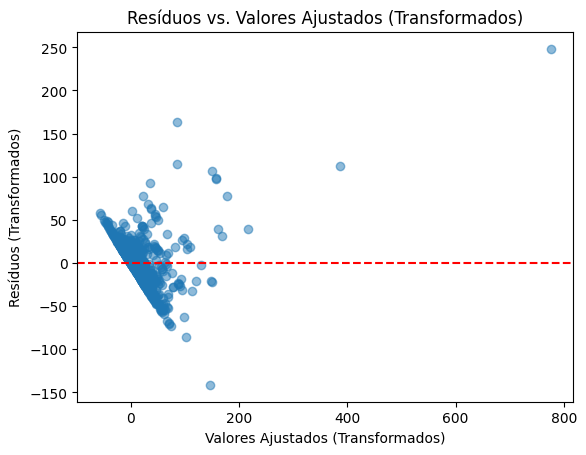

In [ ]:

# Plotar resíduos vs valores ajustados com variáveis transformadas
plt.scatter(y_pred_transformed, residuals_transformed, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Ajustados (Transformados)')
plt.ylabel('Resíduos (Transformados)')
plt.title('Resíduos vs. Valores Ajustados (Transformados)')
plt.show()

In [ ]:

# Teste de Breusch-Pagan para heterocedasticidade
_, pval, _, _ = sm.stats.diagnostic.het_breuschpagan(residuals_transformed, sm.add_constant(X_train_transformed))
print("p-valor do teste de Breusch-Pagan:", pval)

p-valor do teste de Breusch-Pagan: 4.22485646654885e-06


In [ ]:

# Validação Cruzada
scores = cross_val_score(model_transformed, X_train_transformed, y_train, cv=5, scoring='neg_mean_squared_error')
print("RMSE médio com validação cruzada:", np.sqrt(-scores.mean()))


RMSE médio com validação cruzada: 449904839724010.8


In [ ]:

# Adicionar termos polinomiais ou de interação (exemplo com termos quadráticos)
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [ ]:

# Ajustar o modelo polinomial
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

LinearRegression()

In [ ]:

# Previsões e resíduos com modelo polinomial
y_pred_poly = model_poly.predict(X_train_poly)
residuals_poly = y_train - y_pred_poly

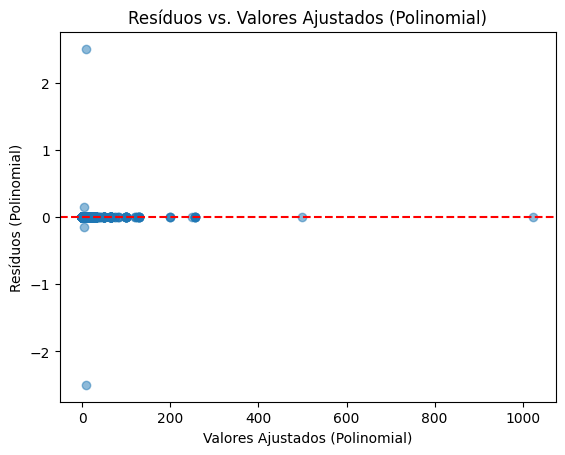

In [ ]:
# Plotar resíduos vs valores ajustados com modelo polinomial
plt.scatter(y_pred_poly, residuals_poly, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Ajustados (Polinomial)')
plt.ylabel('Resíduos (Polinomial)')
plt.title('Resíduos vs. Valores Ajustados (Polinomial)')
plt.show()


In [ ]:

# Repetir validação cruzada com modelo polinomial
scores_poly = cross_val_score(model_poly, X_train_poly, y_train, cv=5, scoring='neg_mean_squared_error')
print("RMSE médio com validação cruzada (polinomial):", np.sqrt(-scores_poly.mean()))


RMSE médio com validação cruzada (polinomial): 165.16490510349615


In [ ]:
from sklearn.linear_model import Ridge, Lasso

# Ajuste do modelo polinomial com Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_poly, y_train)
scores_ridge = cross_val_score(ridge, X_train_poly, y_train, cv=5, scoring='neg_mean_squared_error')
print("RMSE médio com validação cruzada (polinomial + Ridge):", np.sqrt(-scores_ridge.mean()))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=2.62368e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=1.34189e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", ov

RMSE médio com validação cruzada (polinomial + Ridge): 165.27102783004582


In [ ]:


# Ajuste do modelo polinomial com Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_poly, y_train)
scores_lasso = cross_val_score(lasso, X_train_poly, y_train, cv=5, scoring='neg_mean_squared_error')
print("RMSE médio com validação cruzada (polinomial + Lasso):", np.sqrt(-scores_lasso.mean()))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.504e+03, tolerance: 2.128e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.749e+03, tolerance: 9.975e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.000e+03, tolerance: 1.877e

RMSE médio com validação cruzada (polinomial + Lasso): 67.23706775864851


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.547e+03, tolerance: 1.909e+02
  model = cd_fast.enet_coordinate_descent(


Nova forma

Linear Regression RMSE: 4.4225326470394055
Polynomial Regression (degree=2) RMSE: 2.0603889471880548
Lasso Regression RMSE: 3.1510869812127735
SVM Regression RMSE: 3.414007182605301
Breusch-Pagan test p-value: 5.914504432854165e-20


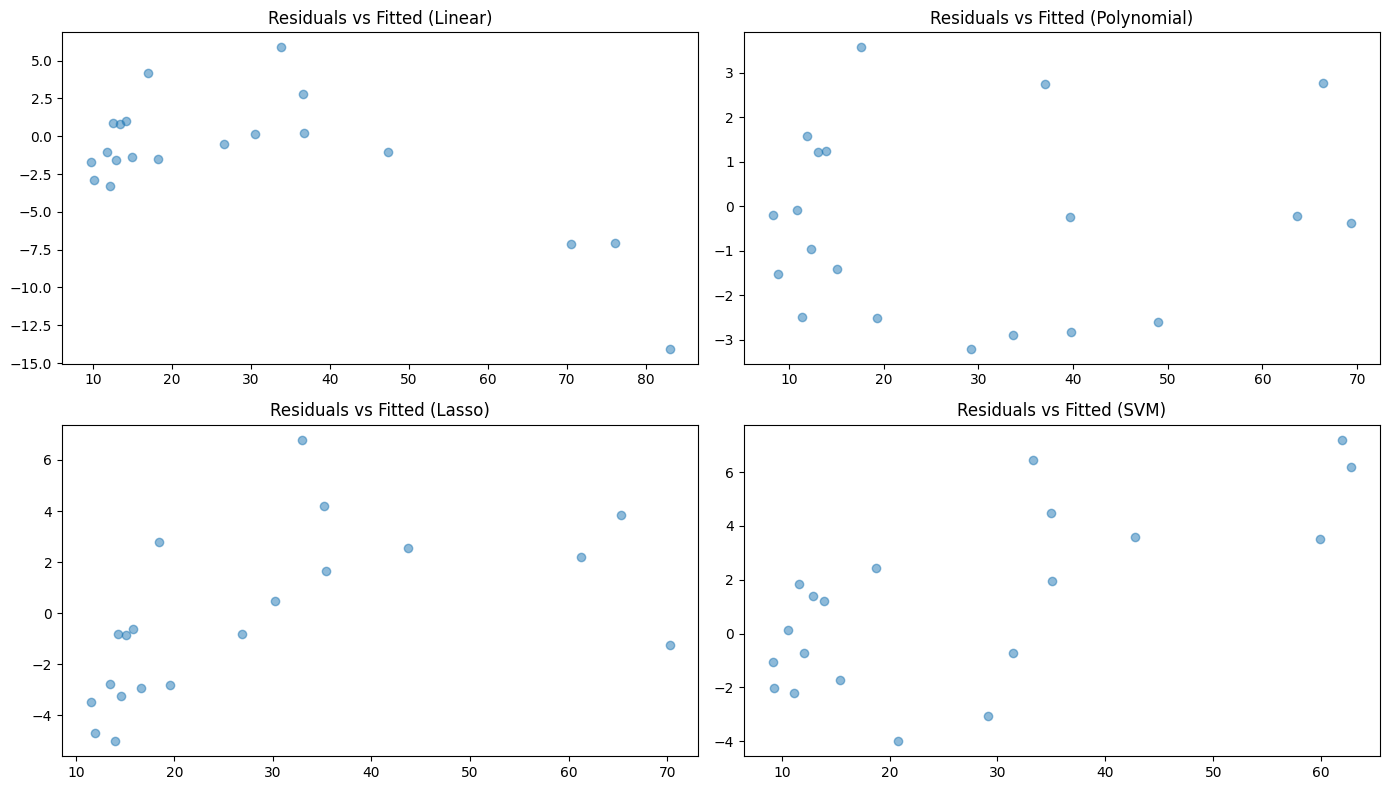

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tools import add_constant

# Load your dataset
df = pd.read_csv('/content/CERTO_MIC_final_com_featuress.csv')
# For demonstration, we use synthetic data
np.random.seed(0)
X = np.random.uniform(1, 10, (100, 1))
y = 5 + 2 * X.flatten() + 0.5 * X.flatten()**2 + np.random.normal(0, 2, 100)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Apply log transformation to address heteroscedasticity
y_train_log = np.log(y_train + 1e-10)  # Add a small constant to avoid log(0)
y_test_log = np.log(y_test + 1e-10)

# Fit and evaluate Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train_log)
linear_predictions_log = linear_model.predict(X_test)
linear_predictions = np.exp(linear_predictions_log)

# Calculate RMSE
linear_rmse = np.sqrt(mean_squared_error(y_test, linear_predictions))
print(f'Linear Regression RMSE: {linear_rmse}')

# Fit and evaluate Polynomial Regression
degree = 2
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_log)
poly_predictions_log = poly_model.predict(X_test_poly)
poly_predictions = np.exp(poly_predictions_log)

# Calculate RMSE
poly_rmse = np.sqrt(mean_squared_error(y_test, poly_predictions))
print(f'Polynomial Regression (degree={degree}) RMSE: {poly_rmse}')

# Fit and evaluate Lasso Regression
lasso_model = make_pipeline(StandardScaler(), Lasso(alpha=0.1))
lasso_model.fit(X_train, y_train_log)
lasso_predictions_log = lasso_model.predict(X_test)
lasso_predictions = np.exp(lasso_predictions_log)

# Calculate RMSE
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_predictions))
print(f'Lasso Regression RMSE: {lasso_rmse}')

# Fit and evaluate SVM Regression
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svm_model.fit(X_train, y_train_log)
svm_predictions_log = svm_model.predict(X_test)
svm_predictions = np.exp(svm_predictions_log)

# Calculate RMSE
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_predictions))
print(f'SVM Regression RMSE: {svm_rmse}')

# Check heteroscedasticity using Breusch-Pagan test
X_with_const = add_constant(X)  # Add a constant term for the intercept
residuals = y - linear_model.predict(X)
bp_test = het_breuschpagan(residuals, X_with_const)
print(f'Breusch-Pagan test p-value: {bp_test[1]}')

# Plot residuals
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.scatter(linear_predictions, y_test - linear_predictions, alpha=0.5)
plt.title('Residuals vs Fitted (Linear)')

plt.subplot(2, 2, 2)
plt.scatter(poly_predictions, y_test - poly_predictions, alpha=0.5)
plt.title('Residuals vs Fitted (Polynomial)')

plt.subplot(2, 2, 3)
plt.scatter(lasso_predictions, y_test - lasso_predictions, alpha=0.5)
plt.title('Residuals vs Fitted (Lasso)')

plt.subplot(2, 2, 4)
plt.scatter(svm_predictions, y_test - svm_predictions, alpha=0.5)
plt.title('Residuals vs Fitted (SVM)')

plt.tight_layout()
plt.show()


In [2]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import HuberRegressor
import matplotlib.pyplot as plt

# Additional transformations and model fitting

# Higher-degree Polynomial Regression
degree = 3
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_log)
poly_predictions_log = poly_model.predict(X_test_poly)
poly_predictions = np.exp(poly_predictions_log)

# Calculate RMSE
poly_rmse = np.sqrt(mean_squared_error(y_test, poly_predictions))
print(f'Higher-Degree Polynomial Regression (degree={degree}) RMSE: {poly_rmse}')

# Robust Regression: Huber Regressor
huber_model = HuberRegressor()
huber_model.fit(X_train, y_train_log)
huber_predictions_log = huber_model.predict(X_test)
huber_predictions = np.exp(huber_predictions_log)

# Calculate RMSE
huber_rmse = np.sqrt(mean_squared_error(y_test, huber_predictions))
print(f'Huber Regression RMSE: {huber_rmse}')

# SVM Regression with Grid Search (optional)
from sklearn.model_selection import GridSearchCV

svm_model = SVR()
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.3]
}
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train_log)
best_svm_model = grid_search.best_estimator_
svm_predictions_log = best_svm_model.predict(X_test)
svm_predictions = np.exp(svm_predictions_log)

# Calculate RMSE
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_predictions))
print(f'Optimized SVM Regression RMSE: {svm_rmse}')


Higher-Degree Polynomial Regression (degree=3) RMSE: 2.0217318679442218
Huber Regression RMSE: 3.818038035805493
Optimized SVM Regression RMSE: 2.0657960579379977


In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Define RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Cross-validate Polynomial Regression
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_log)
poly_cv_scores = cross_val_score(poly_model, X_train_poly, y_train_log, cv=5, scoring=rmse_scorer)
poly_cv_rmse = np.sqrt(-poly_cv_scores.mean())
print(f'Cross-validated Polynomial Regression RMSE: {poly_cv_rmse}')

# Cross-validate Optimized SVM Regression
svm_cv_scores = cross_val_score(best_svm_model, X_train, y_train_log, cv=5, scoring=rmse_scorer)
svm_cv_rmse = np.sqrt(-svm_cv_scores.mean())
print(f'Cross-validated Optimized SVM Regression RMSE: {svm_cv_rmse}')


Cross-validated Polynomial Regression RMSE: 0.10961475259167797
Cross-validated Optimized SVM Regression RMSE: 0.11921975638151769


In [4]:
from sklearn.metrics import r2_score

# For Polynomial Regression
poly_predictions_log = poly_model.predict(X_test_poly)
poly_predictions = np.exp(poly_predictions_log)
poly_r2 = r2_score(y_test, poly_predictions)
print(f'Polynomial Regression R^2: {poly_r2}')

# For Optimized SVM Regression
svm_predictions_log = best_svm_model.predict(X_test)
svm_predictions = np.exp(svm_predictions_log)
svm_r2 = r2_score(y_test, svm_predictions)
print(f'Optimized SVM Regression R^2: {svm_r2}')


Polynomial Regression R^2: 0.989821009549716
Optimized SVM Regression R^2: 0.9893724665147929


In [5]:
from sklearn.metrics import r2_score

# Fit and evaluate Polynomial Regression
degree = 3
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_log)
poly_predictions_log = poly_model.predict(X_test_poly)
poly_predictions = np.exp(poly_predictions_log)

# Calculate RMSE and R^2
poly_rmse = np.sqrt(mean_squared_error(y_test, poly_predictions))
poly_r2 = r2_score(y_test, poly_predictions)
print(f'Polynomial Regression (degree={degree}) RMSE: {poly_rmse}')
print(f'Polynomial Regression R^2: {poly_r2}')

# Fit and evaluate Optimized SVM Regression
svm_predictions_log = best_svm_model.predict(X_test)
svm_predictions = np.exp(svm_predictions_log)

# Calculate RMSE and R^2
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_predictions))
svm_r2 = r2_score(y_test, svm_predictions)
print(f'Optimized SVM Regression RMSE: {svm_rmse}')
print(f'Optimized SVM Regression R^2: {svm_r2}')


Polynomial Regression (degree=3) RMSE: 2.0217318679442218
Polynomial Regression R^2: 0.989821009549716
Optimized SVM Regression RMSE: 2.0657960579379977
Optimized SVM Regression R^2: 0.9893724665147929


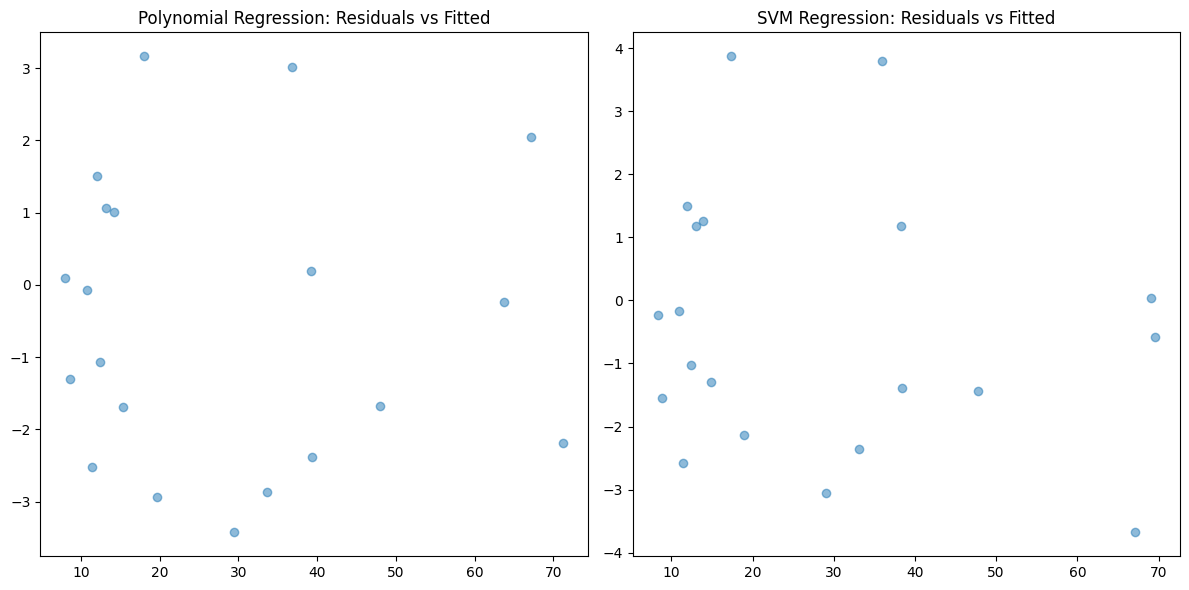

In [6]:
import matplotlib.pyplot as plt

# Plot residuals for Polynomial Regression
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(poly_predictions, y_test - poly_predictions, alpha=0.5)
plt.title('Polynomial Regression: Residuals vs Fitted')

# Plot residuals for SVM Regression
plt.subplot(1, 2, 2)
plt.scatter(svm_predictions, y_test - svm_predictions, alpha=0.5)
plt.title('SVM Regression: Residuals vs Fitted')

plt.tight_layout()
plt.show()


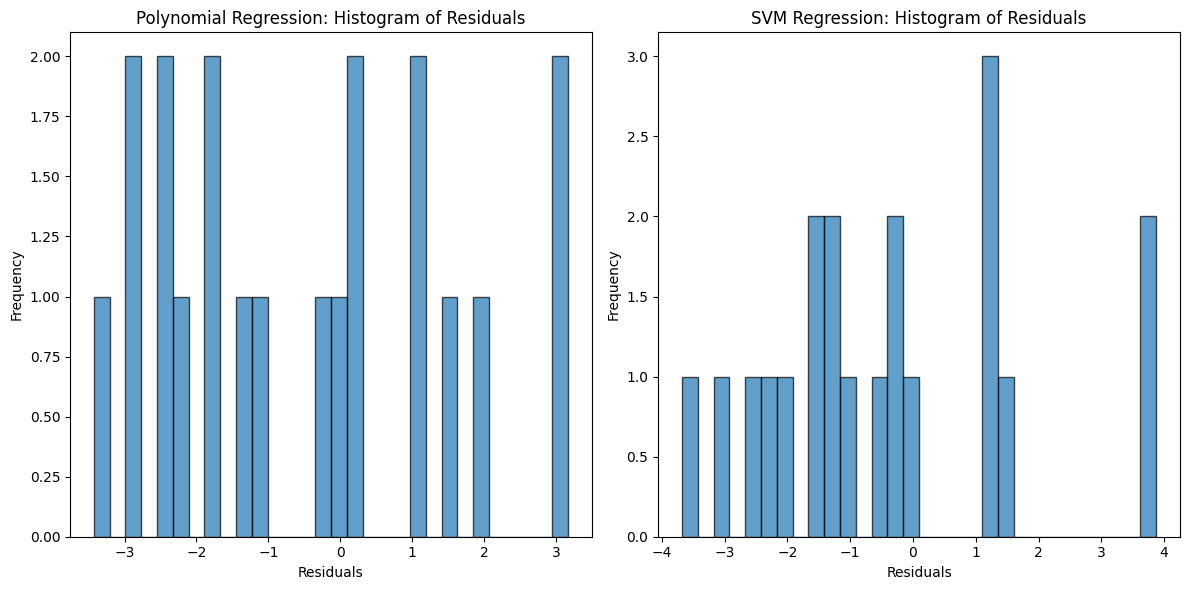

In [7]:
# Histogram of Residuals
plt.figure(figsize=(12, 6))

# Polynomial Regression Residuals Histogram
plt.subplot(1, 2, 1)
plt.hist(y_test - poly_predictions, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Polynomial Regression: Histogram of Residuals')

# SVM Regression Residuals Histogram
plt.subplot(1, 2, 2)
plt.hist(y_test - svm_predictions, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('SVM Regression: Histogram of Residuals')

plt.tight_layout()
plt.show()


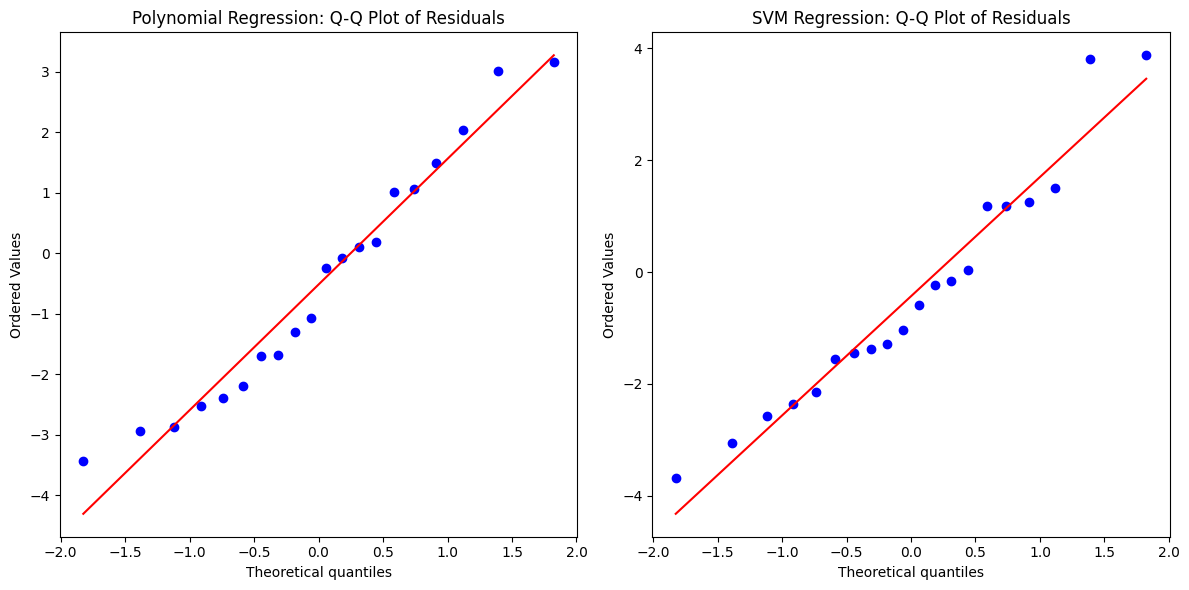

In [8]:
import scipy.stats as stats

# Q-Q Plot of Residuals
plt.figure(figsize=(12, 6))

# Polynomial Regression Q-Q Plot
plt.subplot(1, 2, 1)
stats.probplot(y_test - poly_predictions, dist="norm", plot=plt)
plt.title('Polynomial Regression: Q-Q Plot of Residuals')

# SVM Regression Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(y_test - svm_predictions, dist="norm", plot=plt)
plt.title('SVM Regression: Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()
